# Coursework 2: Robotic behavioural cloning from images and actuator data

# Robotic Behaviour Cloning from Images and Actuator Data  
**Tools & Frameworks**: Python, PyTorch, custom CNNs, Variational Autoencoders (VAEs)  
**Dataset**: [CLVR JACO Play Dataset](https://github.com/clvrai/clvr_jaco_play_dataset?tab=readme-ov-file)

In this project, I developed a behaviour cloning model for robotic control using multi-modal input data consisting of visual and actuator-based observations. The goal was to train a model to mimic robotic actions (e.g., arm movements and gripper commands) using sequences of observations without any pre-trained models or external datasets.

## Dataset Overview
The dataset includes robot arm trajectories as it performs object pick-up or placement tasks, with each timestep containing:
- **Images** from two camera perspectives:
  - `front_cam_ob`: front-facing scene view
  - `mount_cam_ob`: top-down view from a camera mounted above the robotic arm
- **State vectors**:
  - `ee_cartesian_pos_ob`: end-effector Cartesian position and orientation
  - `ee_cartesian_vel_ob`: end-effector velocity
  - `joint_pos_ob`: gripper opening state

Each sample is paired with the ground truth **action**, including:
- A 3D vector specifying how the robot arm should move
- A gripper command: open, close, or hold

## Key Contributions
- **Supervised Behaviour Cloning Model**  
  Built and trained a deep learning model to predict the robot’s next action based on all available observations at a timestep. The model input includes both visual and actuator data, and outputs arm movement commands and gripper state.

- **Model Benchmarking**  
  Evaluated a provided baseline model and developed a custom neural architecture that improved prediction accuracy on the test set.

- **Self-Supervised Representation Learning**  
  Designed and trained a Variational Autoencoder (VAE) to learn compact representations of the robot’s state and visual input without action labels. These learned embeddings were later used as input for the supervised behaviour cloning model.

- **Comparative Evaluation**  
  Conducted a performance comparison between the supervised model trained on raw inputs and the one using VAE-learned representations. This involved consistent dataset splits, fixed random seeds, and custom metrics for loss and action prediction accuracy.


## Data Download and Setup

The dataset used in this project can be downloaded from the following link:  
[CLVR JACO Dataset (Google Drive)](https://drive.usercontent.google.com/download?id=1tVSilmXhyQd8gxZAEhvKMnynw0qzRFSZ&authuser=0)

Once downloaded, the data was saved locally at:
- `../data/all_play_data_diverse` (for local use), or  
- `/content/drive/MyDrive/comp0188_2425/cw2` (for Google Colab)

These paths align with the expected folder structure in the preprocessing scripts. The location can also be updated via the `ROOT_PATH` variable in `config.py` of the provided package.

### `transition_df.csv`

An additional CSV file, `transition_df.csv`, was used to generate train, validation, and test splits. Each row represents a timestep with its associated observations and actions. This file includes **all trajectories**, even those with more than 75 timesteps (which are excluded during training). It is also useful for exploratory data analysis (EDA).

To ensure proper functioning, `transition_df.csv` was placed in the same folder as the raw dataset.

---

## Configuration and Imports

The `comp0188_cw2` package provided configuration tools for running the code locally or in Google Colab. On first import, I configured the following options from the `project_options` module:

- `project_options.collab = True` – Enables compatibility with Google Colab directory structure  
- `project_options.debug = True` – Loads a smaller debug subset of the dataset for faster testing and development

> ⚠️ **Note**: These options must be set immediately after importing `project_options` and **before** loading any other functionality from `comp0188_cw2`, as changing them later may cause unintended behavior.


In [1]:
COLLAB = True
if COLLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install --force-reinstall git+https://github.com/joshuaspear/pymlrf.git
    !pip install wandb
    !pip install torchinfo
    !pip install jaxtyping
    !pip install git+https://github.com/dionferns/comp0188_cw2_public.git
    !pip install typeguard==2.13.3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Cloning https://github.com/joshuaspear/pymlrf.git to /tmp/pip-req-build-j21326te
  Running command git clone --filter=blob:none --quiet https://github.com/joshuaspear/pymlrf.git /tmp/pip-req-build-j21326te
  Resolved https://github.com/joshuaspear/pymlrf.git to commit 2e86313edd7900c1b5621b4e31368a36328b69f8
  Preparing metadata (setup.py) ... done
  Created wheel for pymlrf: filename=pymlrf-1.0.0-py3-none-any.whl size=20447 sha256=d2f17445c560e6bb3845811a4b17ee3d69b5ab842af88bc4a855933dae980bd3
  Stored in directory: /tmp/pip-ephem-wheel-cache-po0whw9k/wheels/b5/e9/53/587b30108dd50ceffb743ada10dd85037096182424fb2c907e
Successfully built pymlrf
  Attempting uninstall: pymlrf
    Found existing installation: pymlrf 1.0.0
    Uninstalling pymlrf-1.0.0:
      Successfully uninstalled pymlrf-1.0.0
  Cloning https://github.com/dionferns/comp0188_cw2_public.git t

Ignore the error:
```ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.```

In [2]:
from comp0188_cw2 import project_options
project_options.collab = COLLAB
print(project_options.collab)
project_options.debug = True
print(project_options.debug)

True
True


In [3]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
import datetime
from pymlrf.Structs.torch import DatasetOutput
import copy

from comp0188_cw2.utils import load_all_files
from torchvision import transforms
import torch
import torch.nn as nn



from torch.utils.data import DataLoader
import datetime
from typing import List
from pymlrf.Structs.torch import DatasetOutput

from comp0188_cw2.config import (
    train_dh, val_dh, test_dh, WANDB_PROJECT
   )
from comp0188_cw2.models.CNNConfig import ConvolutionLayersConfig
from comp0188_cw2.models.base import BaseModel
from comp0188_cw2.models.JointCNNEncoder import JointCNNEncoder
from comp0188_cw2.models.CNN import CNN
from comp0188_cw2.models.MLP import MLP
from comp0188_cw2.Metric.WandBMetricOrchestrator import WandBMetricOrchestrator
from comp0188_cw2.Dataset.NpDictDataset import NpDictDataset
from comp0188_cw2.Loss.BalancedLoss import TrackerBalancedLoss
from comp0188_cw2 import logger
from comp0188_cw2.training.TrainingLoop import TorchTrainingLoop

2025-01-06 14:24:09,769 - pymlrf - WARNING - pymlrf environment variable not set. Logging to file will not be performed (__init__.py:47)


In [ ]:
print(train_dh.loc)

/content/drive/MyDrive/comp0188_2425/cw2/debug/train


## Build the dataset


In [4]:
from comp0188_cw2.Preprocessing import main
RUN_PREPROCESSING = False
if RUN_PREPROCESSING:
  main()

## Tuning an end-to-end supervised learning model taking in the full set of observations and predicting actions

In [5]:
_keys = [
    "actions","front_cam_ob",
    "mount_cam_ob","terminals",
    "ee_cartesian_pos_ob",

    "ee_cartesian_vel_ob",
    "joint_pos_ob"
    ]

train_nps = load_all_files(train_dh.loc,"train_[0-9]+.h5",keys=_keys)
val_nps = load_all_files(val_dh.loc,"val_[0-9]+.h5",keys=_keys)

100%|██████████| 1/1 [00:00<00:00,  6.96it/s]


## Data Preprocessing

Before training the model, I implemented a custom preprocessing pipeline tailored to each modality of the multi-modal input data. This was essential to ensure that both visual and non-visual data were correctly normalized, structured, and converted into PyTorch tensors for efficient loading during training.

The dataset included the following input channels:
- `front_cam_ob`: RGB image from a front-facing camera
- `mount_cam_ob`: Top-down RGB image from a camera mounted above the robotic arm
- `ee_cartesian_pos_ob`: Cartesian position and orientation of the end-effector
- `ee_cartesian_vel_ob`: Cartesian velocity of the end-effector
- `joint_pos_ob`: Gripper position indicating open/close state

For each of these inputs, I defined preprocessing functions using a dictionary structure supported by the custom dataset class provided in the `comp0188_cw2` package. These transformations included:
- **Image data (`front_cam_ob`, `mount_cam_ob`)**: Resizing, normalization to a standard range, and conversion to tensors
- **State vectors (`ee_cartesian_pos_ob`, `ee_cartesian_vel_ob`, `joint_pos_ob`)**: Conversion to tensors with appropriate shape and type

These preprocessing steps ensured that the model received data in a consistent format and allowed for effective batching and training within PyTorch's data loading pipeline.

This preprocessing framework was flexible and modular, allowing easy adjustment of transformation logic per input type and alignment with the model architecture requirements.


In [6]:

from PIL import Image
import torchvision.transforms as transforms

# Calculating min and max values for normalization
min_pos = train_nps["ee_cartesian_pos_ob"].min(axis=0)
max_pos = train_nps["ee_cartesian_pos_ob"].max(axis=0)

min_vel = train_nps["ee_cartesian_vel_ob"].min(axis=0)
max_vel = train_nps["ee_cartesian_vel_ob"].max(axis=0)

min_joint_pos = train_nps["joint_pos_ob"].min(axis=0)
max_joint_pos = train_nps["joint_pos_ob"].max(axis=0)

front_cam_mean = train_nps["front_cam_ob"].mean() / 255.0
front_cam_std = train_nps["front_cam_ob"].std()/ 255.0

mount_cam_mean = train_nps["mount_cam_ob"].mean()/ 255.0
mount_cam_std = train_nps["mount_cam_ob"].std()/ 255.0

# Updated global_transforms with the same augmentation
global_transforms = {
    "front_cam_ob": transforms.Compose([
        transforms.Lambda(lambda x: Image.fromarray(x.astype(np.uint8))),  # Convert to PIL Image
        transforms.Resize((224, 224)),  # Resize to desired input size
        # transforms.RandomRotation(10),  # Apply random rotation augmentation
        # transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Apply brightness and contrast jitter
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[front_cam_mean], std=[front_cam_std])  # Normalize with single-channel mean and std
    ]),

    "mount_cam_ob": transforms.Compose([
        transforms.Lambda(lambda x: Image.fromarray(x.astype(np.uint8))),  # Convert to PIL Image
        transforms.Resize((224, 224)),  # Resize to desired input size
        # transforms.RandomRotation(10),  # Apply random rotation augmentation
        # transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Apply brightness and contrast jitter
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[mount_cam_mean], std=[mount_cam_std])  # Normalize with single-channel mean and std
    ]),

    "actions": lambda x: torch.tensor(x),
    "ee_cartesian_pos_ob": lambda x: (torch.tensor(x) - min_pos) / (max_pos - min_pos + 1e-8),  # Normalize Cartesian position
    "ee_cartesian_vel_ob": lambda x: (torch.tensor(x) - min_vel) / (max_vel - min_vel + 1e-8),  # Normalize Cartesian velocity
    "joint_pos_ob": lambda x: (torch.tensor(x) - min_joint_pos) / (max_joint_pos - min_joint_pos + 1e-8)  # Normalize joint position
}

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


## Justification for preprocessing including where I have decided __not__ to apply preprocessing. I have included empirical evidence from the EDA analysis to support the decisions.

**Actions:**
This data represents commands for the robotic arm’s movements, such as position adjustments or gripper control. Since these values are output targets for the model, it does not contribute to the input features that are processed, hence they don’t affect the input variability henc,e no preprocessing is necessary.

**Front camera observation:**
For this, resizing is done to 224 X 224, these are then normalised using a calculated mean and standard deviation.
This preprocessing is justified by the evidence shown, the front camera images are shown to have a mean pixel intensity of about 114.375 with a wide range of pixel values from 0.53 to 249.5; this normalisation is used to bring the data into a smaller and consistent range, this is used to help model convergence and training stability further.
The images are resized to ensure they are compatible with neural network input dimensions.

**Mounted camera:**
The same preprocessing is done with the front camera since their pixels are similar to them in the range of 1.84 to 254.75 with a mean intensity of 128.25; if we didn’t normalise these images, we would have introduced high variance, which negatively impacts the model performance.

**End effector Cartesian position:**
The Min-max scaling formula is used since the position data ranges from -0.36, 0.988] by normalising these values, we make sure the values are scaled to a good consistent range for all dimensions; this prevents any problems caused by high magnitudes.

**End effector cartesian velocity:**
Min-max normalisation
Normalisation ensures velocity features contribute equally to the learning process, avoiding bias that could have led to high variance.

**Joint position observation:**
Min-max normalisation.
It ranges from 0 to 1.38; hence, it has high variability. Hence, normalisation is used to get the values within the standard range.


Front Camera Observation Statistics:
Min: 0.52685546875
Max: 249.5
Mean: 114.375
Std: inf


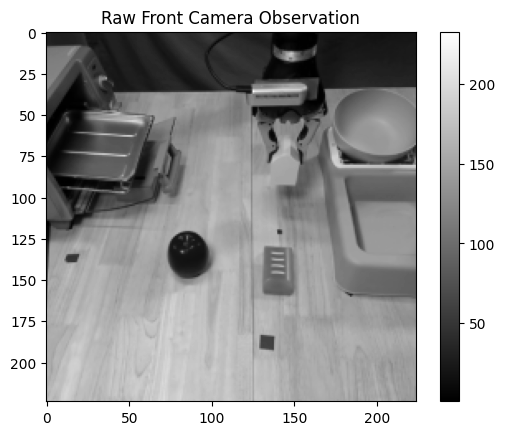


Mounted Camera Observation Statistics:
Min: 1.8408203125
Max: 254.75
Mean: 128.25
Std: inf


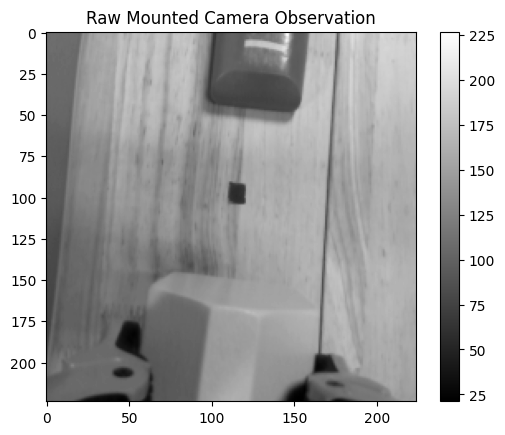


End Effector Cartesian Position Statistics:
Min: [-0.3687   -0.607     0.1699   -0.003897 -0.02531   0.988     0.09814 ]
Max: [ 0.1544   -0.2583    0.3625    0.01495   0.001171  0.995     0.1547  ]
Mean: [-0.0664   -0.4255    0.2634    0.004578 -0.01123   0.991     0.1329  ]
Std: [0.1146   0.083    0.04947  0.003605 0.006084 0.00828  0.01219 ]

End Effector Cartesian Velocity Statistics:
Min: [-0.2202 -0.2659 -0.3164 -0.1943 -0.0934 -0.1095]
Max: [0.3364 0.2722 0.3892 0.1042 0.0822 0.3054]
Mean: [ 0.011856  -0.010254  -0.011345   0.0001974 -0.003073   0.001399 ]
Std: [0.0998  0.1023  0.1229  0.02548 0.02089 0.03226]

Joint Position Observation Statistics:
Min: [0. 0.]
Max: [1.399 1.379]
Mean: [0.812  0.7993]
Std: [0.3933 0.3882]

Example Normalized Cartesian Position (First 5 Rows):
[[0.6323 0.563  0.5957 0.4592 0.705  0.2    0.8423]
 [0.6323 0.563  0.5957 0.4595 0.704  0.2    0.8423]
 [0.6323 0.563  0.5957 0.4587 0.7085 0.2    0.8423]
 [0.6323 0.5625 0.6045 0.466  0.708  0.2    0.846

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Summary of front_cam_ob
print("Front Camera Observation Statistics:")
print(f"Min: {train_nps['front_cam_ob'].min()}")
print(f"Max: {train_nps['front_cam_ob'].max()}")
print(f"Mean: {train_nps['front_cam_ob'].mean()}")
print(f"Std: {train_nps['front_cam_ob'].std()}")

plt.imshow(train_nps["front_cam_ob"][0], cmap='gray')
plt.title("Raw Front Camera Observation")
plt.colorbar()
plt.show()

# Summary of mount_cam_ob
print("\nMounted Camera Observation Statistics:")
print(f"Min: {train_nps['mount_cam_ob'].min()}")
print(f"Max: {train_nps['mount_cam_ob'].max()}")
print(f"Mean: {train_nps['mount_cam_ob'].mean()}")
print(f"Std: {train_nps['mount_cam_ob'].std()}")

plt.imshow(train_nps["mount_cam_ob"][0], cmap='gray')
plt.title("Raw Mounted Camera Observation")
plt.colorbar()
plt.show()

# Cartesian Position Statistics
print("\nEnd Effector Cartesian Position Statistics:")
print(f"Min: {train_nps['ee_cartesian_pos_ob'].min(axis=0)}")
print(f"Max: {train_nps['ee_cartesian_pos_ob'].max(axis=0)}")
print(f"Mean: {train_nps['ee_cartesian_pos_ob'].mean(axis=0)}")
print(f"Std: {train_nps['ee_cartesian_pos_ob'].std(axis=0)}")

# Cartesian Velocity Statistics
print("\nEnd Effector Cartesian Velocity Statistics:")
print(f"Min: {train_nps['ee_cartesian_vel_ob'].min(axis=0)}")
print(f"Max: {train_nps['ee_cartesian_vel_ob'].max(axis=0)}")
print(f"Mean: {train_nps['ee_cartesian_vel_ob'].mean(axis=0)}")
print(f"Std: {train_nps['ee_cartesian_vel_ob'].std(axis=0)}")

# Joint Position Statistics
print("\nJoint Position Observation Statistics:")
print(f"Min: {train_nps['joint_pos_ob'].min(axis=0)}")
print(f"Max: {train_nps['joint_pos_ob'].max(axis=0)}")
print(f"Mean: {train_nps['joint_pos_ob'].mean(axis=0)}")
print(f"Std: {train_nps['joint_pos_ob'].std(axis=0)}")

# Visualizing Normalized Data
min_pos, max_pos = train_nps["ee_cartesian_pos_ob"].min(axis=0), train_nps["ee_cartesian_pos_ob"].max(axis=0)
normalized_pos = (train_nps["ee_cartesian_pos_ob"] - min_pos) / (max_pos - min_pos + 1e-8)
print("\nExample Normalized Cartesian Position (First 5 Rows):")
print(normalized_pos[:5])

### End-to-end supervised model evaluation
The code below defines an end to end supervised model which:
- Jointly encodes the two images ("front_cam_ob", "mount_cam_ob") using a CNN architecture (image_encoder);
- Seperately encoding the positional and velocity observations using an MLP;
- Combines the two embeddings by adding them together and;
- Passes the combined embedding into a final MLP layer (dense)
  
Here i have defined sutable loss functions for the model and then evaluate the performance.

In [ ]:
cnn2_config = ConvolutionLayersConfig(
    input_dim=224,
    input_channels=2,
    layers=[
        nn.Conv2d(
            in_channels=2,
            out_channels=8,
            kernel_size=(3,3),
            stride=1,
            padding=1,
            dilation=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))
        ]
    )

_cnn_output_dim = cnn2_config.get_output_dims()
_cnn_output_channels = cnn2_config.get_output_channels()
_mlp_input_dim = int(
            (_cnn_output_dim[-1]*_cnn_output_dim[-1])*_cnn_output_channels[-1]
            )


image_encoder = JointCNNEncoder(
    cnn=CNN(cnn2_config),
    dense=MLP(
        input_dim=_mlp_input_dim,
        hidden_dims=[256],
        output_dim=128
        )
)

obs_encoder = MLP(
    input_dim = 15,
    hidden_dims = [256,256],
    output_dim = 128
)

dense = MLP(
    input_dim = 128,
    hidden_dims = [64,32],
    output_dim = 6
)

class Baseline1(BaseModel):

  def __init__(
      self,
      image_encoder:JointCNNEncoder,
      obs_encoder:MLP,
      dense:MLP
      ) -> None:
      super().__init__()
      self.image_encoder = image_encoder
      self.obs_encoder = obs_encoder
      self.dense = dense

  def forward(self, images, obs):
    _img_enc = self.image_encoder(images)
    _obs_enc = self.obs_encoder(obs)
    _dense_enc = self.dense(_img_enc+_obs_enc)
    pos = _dense_enc[:,0:3]
    grp = _dense_enc[:,3:]
    return {
        "pos": pos,
        "grp":grp
        }
  def reset(
      self,
      image_encoder_kwargs,
      obs_encoder_kwargs,
      dense_kwargs
      ):
    self.image_encoder.reset(**image_encoder_kwargs)
    self.obs_encoder.reset(**obs_encoder_kwargs)
    self.dense.reset(**dense_kwargs)

torch.manual_seed(1)
model = Baseline1(
    image_encoder=image_encoder,
    obs_encoder=obs_encoder,
    dense=dense
)



## Loss definitions
For the model defined above, the proposed loss function is defined where the contribution of "pos_criterion" and "grp_criterion" are equally weighted and the mean of the two values loss are used to define the final loss. Furthermore, the loss for the positional actions is the MSE and the loss for grp_criterion is the CrossEntropyLoss.

- Justify why this composite loss function is reasonable. You should make reference to the range of values predicted by the deep learning model.

MSE loss is used for positional actions since it ensures the the model minimises the squared error between the predicted and actual positions, this is especially excellent for continuous outputs as it penalises large deviations more.

For gripper actions, cross-entropy loss is used as it is used to predict categorical labels, this loss is the standard choice for multi-class classification due to its ability to assign high probabilities to the correct class along with helping to penalise incorrect predictions

Furthermore, the mean is also taken equally, which is important because both outputs contribute equally to the overall robotic behaviour.


In [ ]:
pos_criterion = nn.MSELoss(reduction="mean")
grp_criterion = nn.CrossEntropyLoss(reduction="mean")

In [15]:

torch.manual_seed(1)
model.reset({},{},{})
exp_kwargs = {
    "batch_size": 64,
    "learning_rate": 0.001,
    "half_precision": True,
    "target_offset": 0
}

if project_options.debug:
    exp_kwargs["batch_size"] = 4

if exp_kwargs["half_precision"]:
    train_dataset = NpDictDataset(
        array_dict=train_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict=val_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )
else:
    train_dataset = NpDictDataset(
        array_dict={k:train_nps[k].astype(np.float32) for k in train_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict={k:val_nps[k].astype(np.float32) for k in val_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

print(len(train_dataset))
out = train_dataset[0]

def collate_func(input_list:List[DatasetOutput])->DatasetOutput:
    pos = []
    _grp = []
    images = []
    obs = []
    for val in input_list:
        images.append(
            torch.concat(
                [val.input["front_cam_ob"], val.input["mount_cam_ob"]],
                dim=0
            )[None,:]
            )
        obs.append(
            torch.concat(
                [
                    val.input["ee_cartesian_pos_ob"],
                    val.input["ee_cartesian_vel_ob"],
                    val.input["joint_pos_ob"]
                    ],
                dim=0
            )[None,:]
        )
        pos.append(val.output["actions"][0:3][None,:])
        _grp.append(val.output["actions"][-1:][None])
    _grp = torch.concat(_grp, dim=0)
    grp = torch.zeros(_grp.shape[0],3)
    grp[torch.arange(len(grp)), _grp.squeeze().int()] = 1
    return DatasetOutput(
        input = {
            "images":torch.concat(images,dim=0),
            "obs":torch.concat(obs,dim=0),
            },
        output = {
            "pos":torch.concat(pos, dim=0),
            "grp":grp
            }
    )


train_dataloader = DataLoader(
    train_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=True,
    collate_fn=collate_func,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=False,
    collate_fn=collate_func,
)

first_batch = next(train_dataloader.__iter__())

input_dim = first_batch.input["images"].shape
print(input_dim)
input_dim = first_batch.input["obs"].shape
print(input_dim)
pos_dim = first_batch.output["pos"].shape
print(pos_dim)
grp_dim = first_batch.output["grp"].shape
print(grp_dim)

exp_kwargs["model_def"] = model.__repr__()


if exp_kwargs["half_precision"]:
    model = model.half()  # Convert model to half-precision

    # Iterate through the model's layers and cast biases to float16 if they are not already
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):  # Check for convolutional and linear layers
            if module.bias is not None and module.bias.dtype != torch.float16:
                module.bias = module.bias.half()  # Cast bias to float16
else:
    # Ensure model is in full precision (float32) if half_precision is False
    model = model.float()  # Convert model to full precision if using FP32

    # Iterate through the model's layers and cast biases to float32
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            if module.bias is not None and module.bias.dtype != torch.float32:
                module.bias = module.bias.float()

optimizer = torch.optim.Adam(
    model.parameters(), lr=exp_kwargs["learning_rate"],
    eps=1e-04
    )


__criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":pos_criterion,
        "grp": grp_criterion
    }
    )

if exp_kwargs["half_precision"]:
    with torch.no_grad():
        if torch.cuda.is_available():
            model = model.cuda()
            with torch.autocast(device_type="cuda"):
                res = model(
                    images=first_batch.input["images"].cuda(),
                    obs=first_batch.input["obs"].cuda()
                    )
                first_batch.output["pos"] = first_batch.output["pos"].cuda()
                first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            with torch.autocast(device_type="cpu"):
                res = model(
                    images=first_batch.input["images"],
                    obs=first_batch.input["obs"]
                    )
else:
    with torch.no_grad():
        if torch.cuda.is_available():
            model = model.cuda()
            res = model(
                images=first_batch.input["images"].cuda(),
                obs=first_batch.input["obs"].cuda()
                )
            first_batch.output["pos"] = first_batch.output["pos"].cuda()
            first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            res = model(
                images=first_batch.input["images"],
                obs=first_batch.input["obs"]
                )
print(__criterion(res,first_batch.output))


1274
torch.Size([4, 2, 224, 224])
torch.Size([4, 15])
torch.Size([4, 3])
torch.Size([4, 3])
tensor(0.5264, device='cuda:0', dtype=torch.float16)


In [ ]:
mo = WandBMetricOrchestrator()
import wandb
train_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="train",
    mo=mo
    )

val_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="val",
    mo=mo
    )

sl_trainer = TorchTrainingLoop(
    model=model, gpu=True, optimizer=optimizer, criterion=train_criterion,
    val_criterion=val_criterion, epochs=10, logger=logger,
    mo=WandBMetricOrchestrator(), half_precision=exp_kwargs["half_precision"],
    preds_save_type=None
)

wandb_name = "simple_model10epochs"
wandb_grp="End_to_end"

if project_options.debug:
    wandb_name = f"{wandb_name}_DEBUG"


orig = datetime.datetime.now()
sl_trainer.training_loop(
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    wandb_proj=WANDB_PROJECT,
    wandb_grp=wandb_grp,
    wandb_config=exp_kwargs,
    wandb_name=wandb_name,
    reset_kwargs={
        "image_encoder_kwargs": {},
        "obs_encoder_kwargs": {},
        "dense_kwargs": {}
    }
    )
post_train = datetime.datetime.now()
wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


INFO:cw2_logger:Running epochs: 10
INFO:cw2_logger:Running training epoch
100%|██████████| 319/319 [00:10<00:00, 31.65it/s]
INFO:cw2_logger:Epoch 1	 Training Loss: 0.7939453125	Accuracy: 0.6750	 Precision: 0.6784	Recall: 0.6750	 F1: 0.6617
INFO:cw2_logger:Epoch 1	 Validation Loss: 0.6875	Accuracy: 0.7590	 Precision: 0.6541	Recall: 0.7590	 F1: 0.7023
INFO:cw2_logger:Scheduler is None or not initialized.
INFO:cw2_logger:Running training epoch
100%|██████████| 319/319 [00:09<00:00, 32.33it/s]
INFO:cw2_logger:Epoch 2	 Training Loss: 0.6298828125	Accuracy: 0.7370	 Precision: 0.6974	Recall: 0.7370	 F1: 0.6390
INFO:cw2_logger:Epoch 2	 Validation Loss: 0.63037109375	Accuracy: 0.7797	 Precision: 0.6079	Recall: 0.7797	 F1: 0.6832
INFO:cw2_logger:Scheduler is None or not initialized.
INFO:cw2_logger:Running training epoch
100%|██████████| 319/319 [00:09<00:00, 33.45it/s]
INFO:cw2_logger:Epoch 3	 Training Loss: 0.61865234375	Accuracy: 0.6931	 Precision: 0.7603	Recall: 0.6931	 F1: 0.6568
INFO:cw2_l

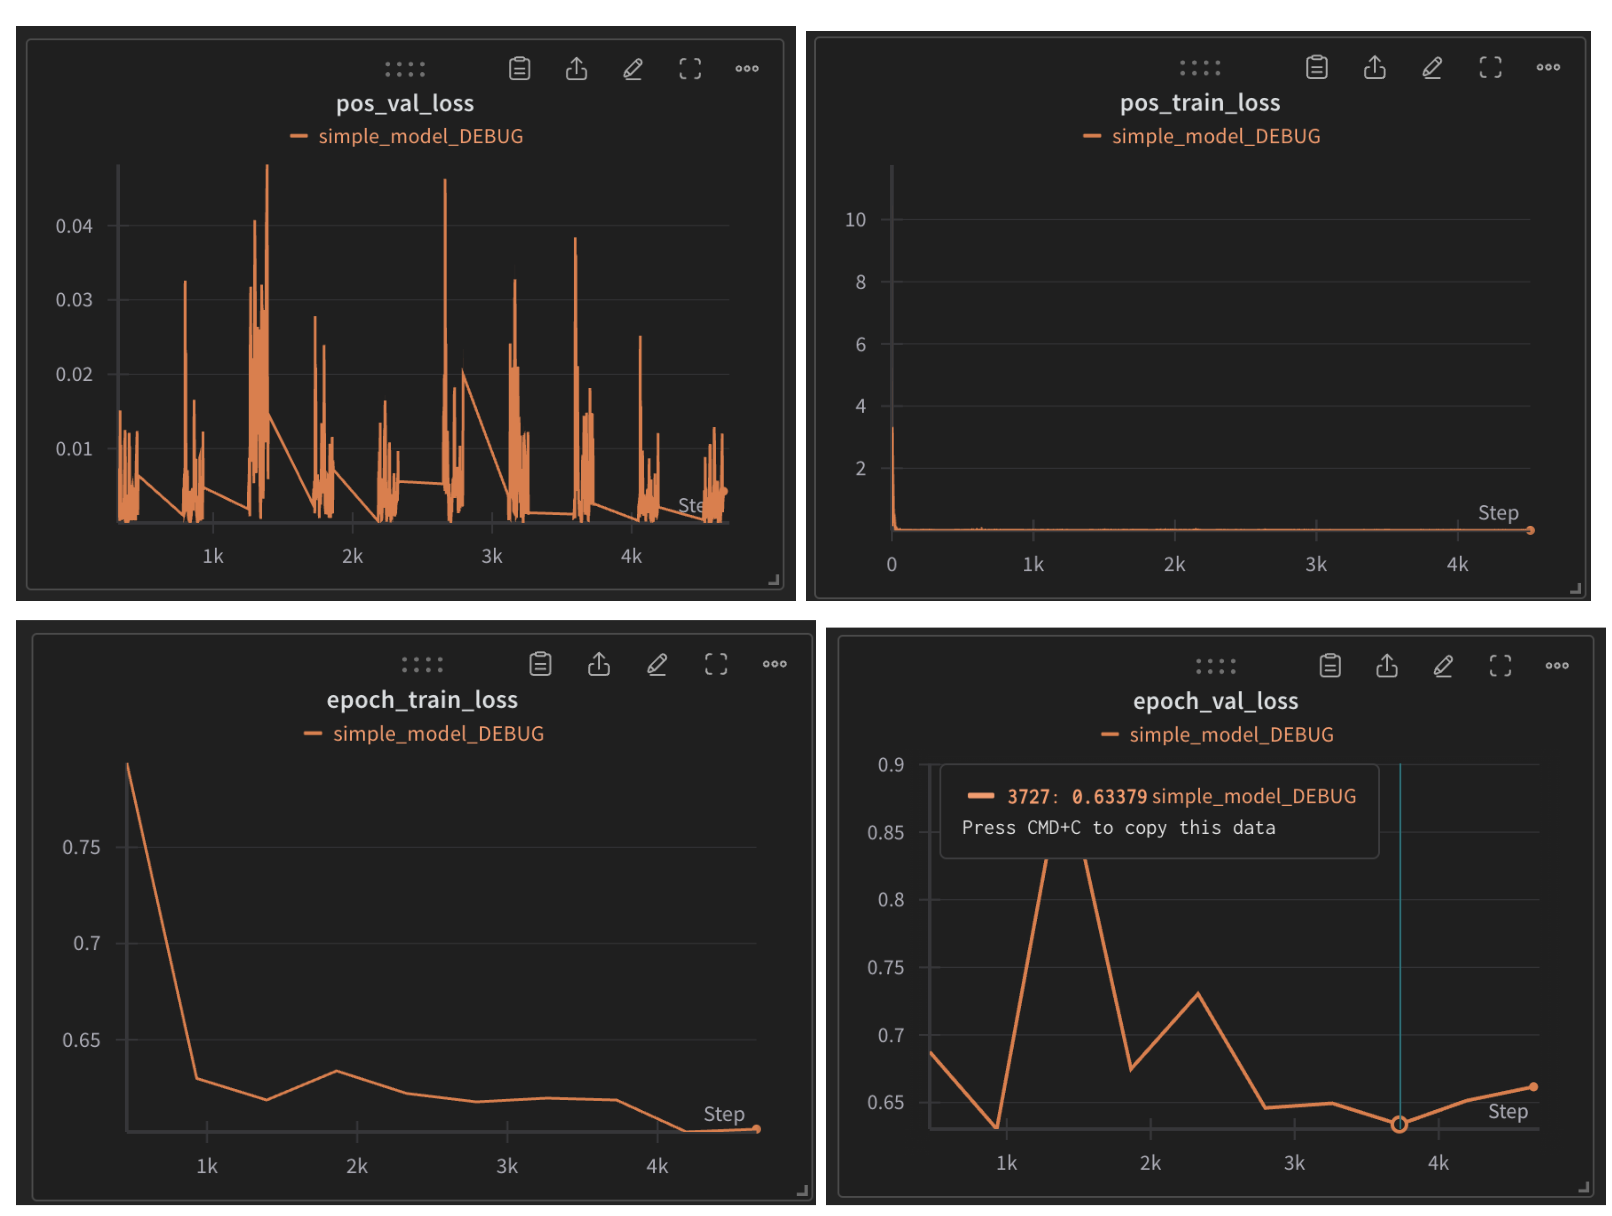

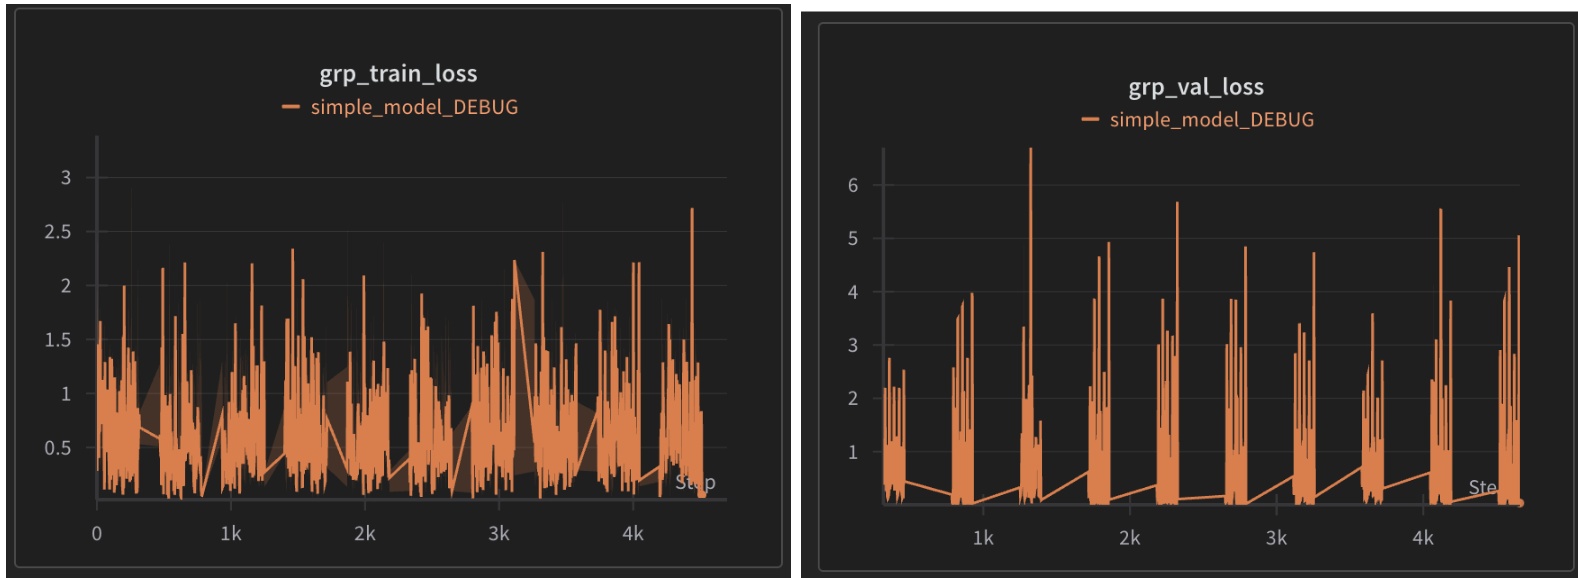

#### Question 1.b.ii Model evaluation (marks broken down in sub questions)
This question requires you to evaluate the perfomance of the model defined above by interpreting model training/validation metrics and investigating the specific failure modes of the model. Run the cells above which will train the model for 10 epochs.

**IMPORTANT, for questions (1.b.ii.i, 1.b.ii.ii, 1.b.ii.ii)**
- You are **not** expected to train a baseline model and you will be awarded **0 marks** for training such a model and evaluating performance against it.
- Furthermore, when interpretting the metric(s) and justifying your conclusions, you will loose marks for failing to comment on striking results that are obvious to the marker.
- **Incorrect interpretations of metrics** will be **negatively penalised**
- Finally, where you have been asked for empirical evidence, but provide none, you will be awarded __0 marks__.

#### Question 1.b.ii.i Epoch selection (3 marks)
##### Task
- Select an appropriate epoch using a suitable method, provide __empirical evidence__ for your choice.

i have selected epoch 40, this is because, right at this epoch, most of the metrics i have used such as recall, precision, losses, accuracy plateau, this specific epoch also allows the model to fully plateay so that any unseen improvement and sharp increase in performance is not missed.

In [ ]:
# model.reset(image_encoder_kwargs={}, obs_encoder_kwargs={}, dense_kwargs={})
import wandb

mo = WandBMetricOrchestrator()
train_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="train",
    mo=mo
    )

val_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="val",
    mo=mo
    )

sl_trainer = TorchTrainingLoop(
    model=model, gpu=True, optimizer=optimizer, criterion=train_criterion,
    val_criterion=val_criterion, epochs=60, logger=logger,
    mo=WandBMetricOrchestrator(), half_precision=exp_kwargs["half_precision"],
    preds_save_type=None
)

wandb_name = "simple60epochs"
wandb_grp="End_to_end"

if project_options.debug:
    wandb_name = f"{wandb_name}_DEBUG"

orig = datetime.datetime.now()
sl_trainer.training_loop(
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    wandb_proj=WANDB_PROJECT,
    wandb_grp=wandb_grp,
    wandb_config=exp_kwargs,
    wandb_name=wandb_name,
    reset_kwargs={
        "image_encoder_kwargs": {},
        "obs_encoder_kwargs": {},
        "dense_kwargs": {}
    }
    )

post_train = datetime.datetime.now()
wandb.finish()

wandb: Currently logged in as: dionfernandes5 (dionfernandes5-university-college-london-ucl-). Use `wandb login --relogin` to force relogin


INFO:cw2_logger:Running epochs: 60
INFO:cw2_logger:Running training epoch
100%|██████████| 319/319 [00:09<00:00, 33.29it/s]
INFO:cw2_logger:Epoch 1	 Training Loss: 0.7158203125	Accuracy: 0.7057	 Precision: 0.6830	Recall: 0.7057	 F1: 0.6841
INFO:cw2_logger:Epoch 1	 Validation Loss: 0.69140625	Accuracy: 0.7642	 Precision: 0.6519	Recall: 0.7642	 F1: 0.7033
INFO:cw2_logger:Scheduler is None or not initialized.
INFO:cw2_logger:Running training epoch
100%|██████████| 319/319 [00:09<00:00, 32.70it/s]
INFO:cw2_logger:Epoch 2	 Training Loss: 0.62744140625	Accuracy: 0.7363	 Precision: 0.6893	Recall: 0.7363	 F1: 0.6385
INFO:cw2_logger:Epoch 2	 Validation Loss: 0.630859375	Accuracy: 0.7797	 Precision: 0.6079	Recall: 0.7797	 F1: 0.6832
INFO:cw2_logger:Scheduler is None or not initialized.
INFO:cw2_logger:Running training epoch
100%|██████████| 319/319 [00:09<00:00, 32.61it/s]
INFO:cw2_logger:Epoch 3	 Training Loss: 0.61669921875	Accuracy: 0.7033	 Precision: 0.7627	Recall: 0.7033	 F1: 0.6588
INFO:cw

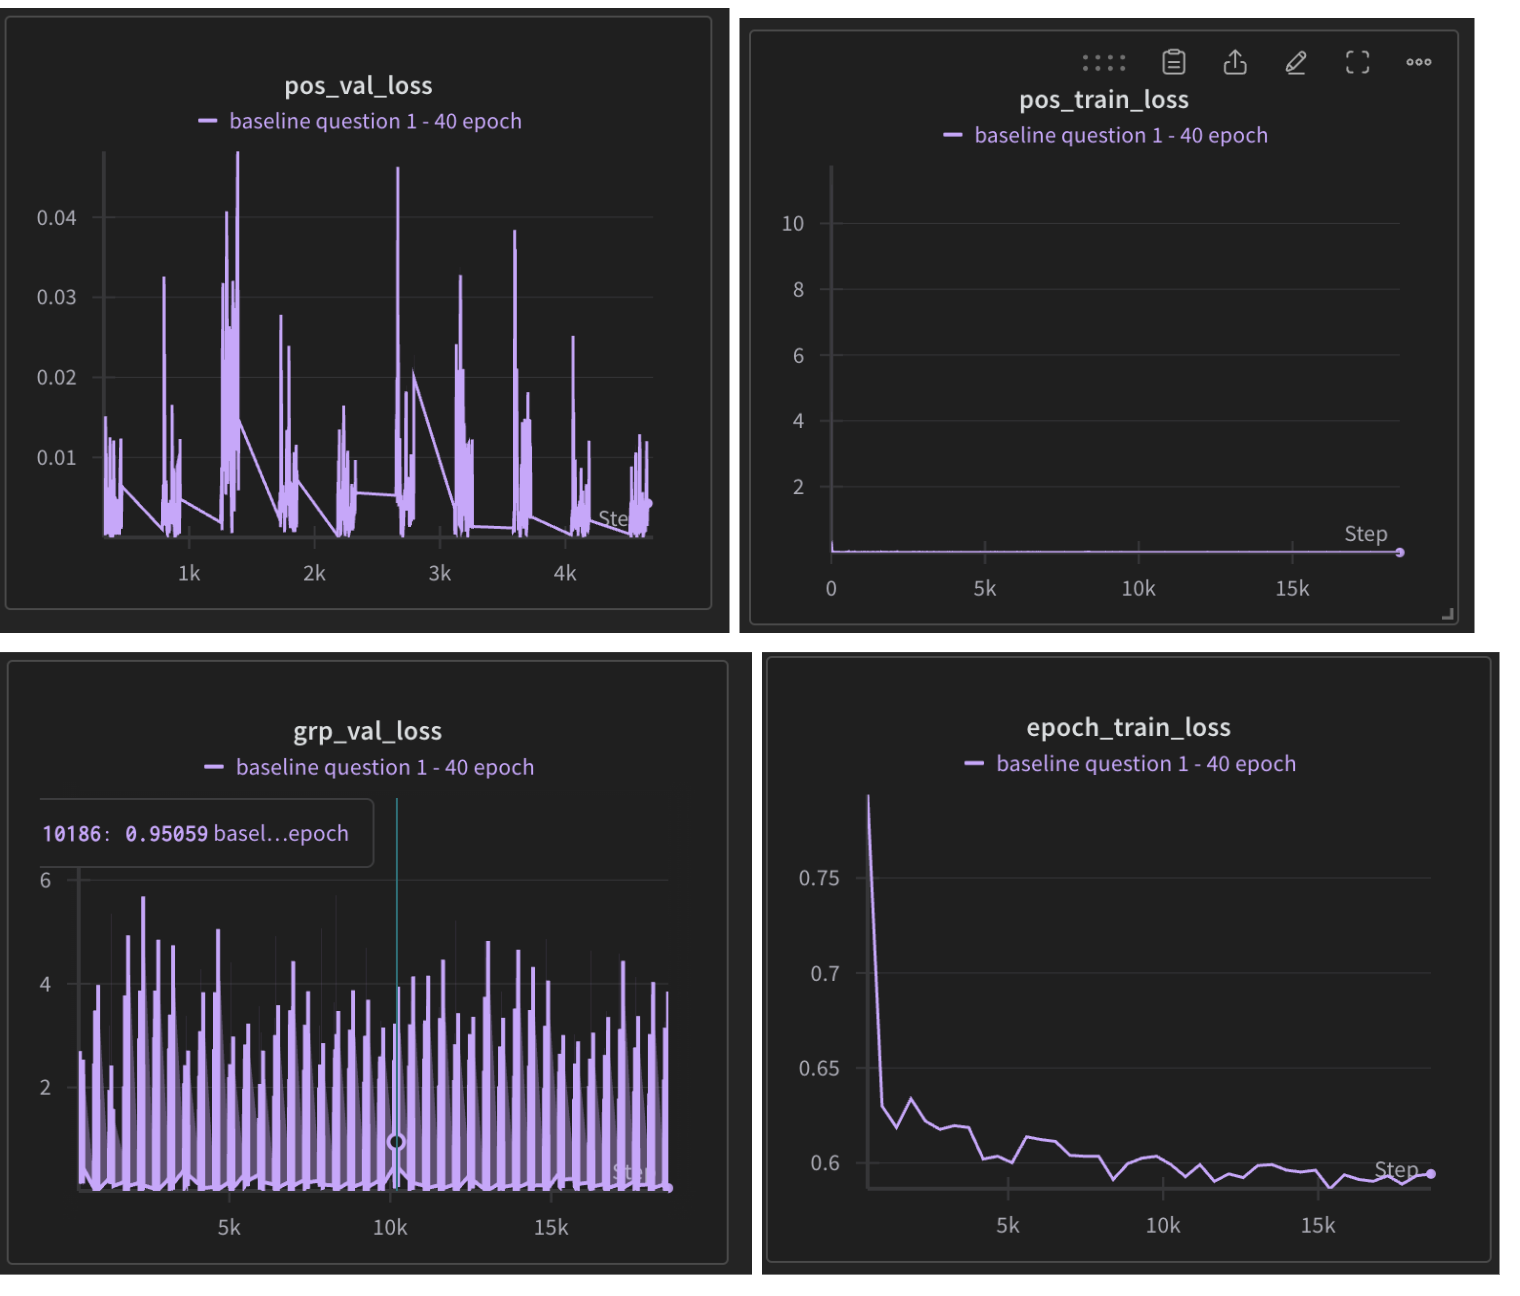

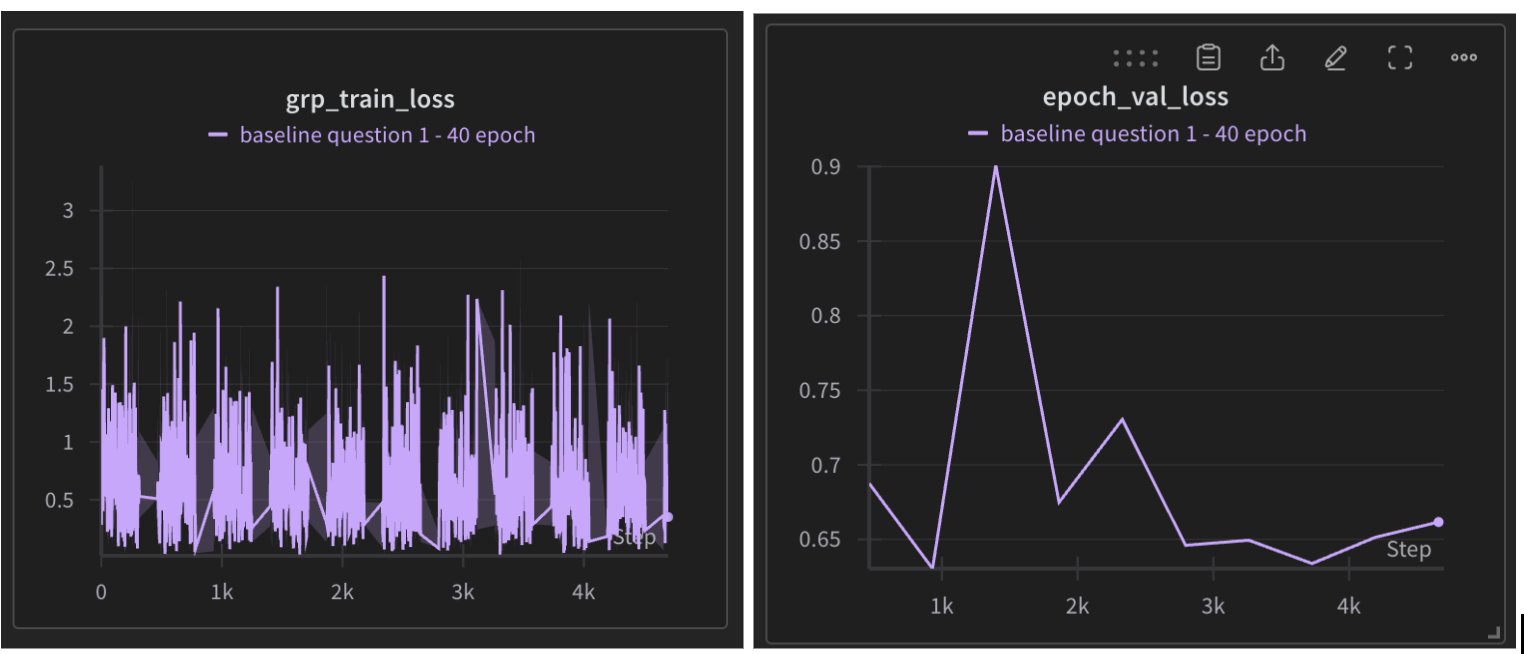

image.png

```
# This is formatted as code
```



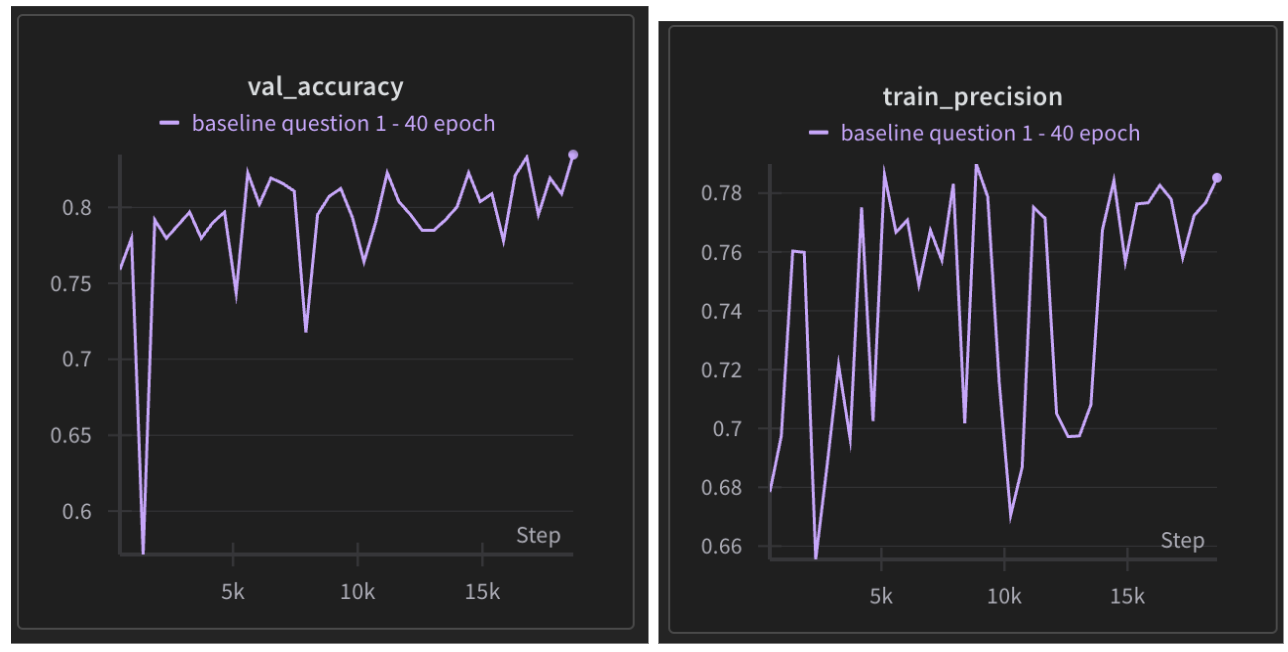

#### Question 1.b.ii.ii Performance evaluation (8 marks)
##### Task
- Draw conclusions regarding how well the model performs. To do this you may want to use additional metrics to the one(s) already reported. Critically, you should __contextualise__ the performance of the model. We are expecting discussion points a long the lines: _The model achieved a score of X according to metric Y. This suggests that the model is/is not performing well, because..._

Here, I have used several evaluation metrics to analyse the performance of my mode.
The F1 score measures the balance between precision and recall, providing a single metric to analyse the model’s ability to identify true positives while reducing false positives and negatives. This is used since it is very effective for imbalanced data, which we have in our data.

Precision is the proportion of correctly predicted positive observations out of the predicted positive observations. This suggests the model's accuracy/precision; this is very important when minimising false positives.

Recall is the proportion of correctly predicted positive observations out of the actual positive observations.
I have identified three key issues with this model.
Firstly, all the evaluation metrics display significant oscillations, suggesting that the model’s training lacks stability and consistency.
This is seen in the precision and recall graphs, which show significant oscillations; the recall metric shows a slightly more stable trend but still fluctuates, further suggesting consistency issues in capturing true positives during the training and validation process.
Also, the F1 score shows considerable instability and oscillations, suggesting that the model finds it difficult to achieve balanced predictions for true and false positives/negatives. The accuracy also shows large larges across epochs. The overall training and validation losses decrease steadily but still show considerable fluctuations, particularly for validation, which could suggest overfitting.

Another issue is poor generalisation: validation losses show poor convergence, suggesting a limited ability to generalise to unseen data.

Furthermore, the grip-related metrics are seen to have little to no improvement over the epochs, this suggests that the training setup is not effectively learning this grip class.


#### Question 1.b.ii.iii Model failure modes (9 marks)
##### Task
- Investigate the failure modes of the model. You should:
  - Demonstrate the failure mode using **empirical evidence** e.g., _the model fails on X observations as demonstrated by..._
  - Assess the impact of these failure modes using **empirical evidence** i.e., how significant is this problem. You should consider both metrics and dataset coverage
  - Conclude __why__ the model might be failing on these observations **empirical evidence** e.g., _X part of the model performs poorly, as demonstrated by..._

__IMPORTANT__:
- Marks will be penalised if the failure modes you identify are not systematic i.e., you select a single observation that the model fails on. If you cannot identify any general failure modes of the model, you will be awarded full marks if you provide empirical evidence justifying why there are no systematic failure modes which sufficienty accounts for the diversity of observations in the dataset.


Instability in metrics: validation precision and recall metrics show large oscillations through the epochs, which suggests inconsistent prediction during validation. The F1 score also fluctuates, indicating the instability in the balance between true positives and false positives/negatives.
VAldiaiton losses, especially for positional and grip tasks, do not decrease consistently but fluctuate, suggesting that the model cannot effectively generalise to unseen data.
The training and validation losses for grip actions are noisy and show minimal improvement. The model has failed to capture the relevant patterns for grip-related tasks.

Some root causes of such failure modes include:
High variance in data:
The significant oscillations in metrics suggest that the model is sensitive to high variance in the dataset. The diverse observations may be causing the model to make inconsistent updates during training.

There might be insufficient representation in the dataset or inadequate task weighting, which the model cannot effectively capture with the current architecture.

Furthermore, this can be a lack of stability in the trained process, which can also be caused by suboptimal hyperparameters(e.g., learning rate or batch size), which might prevent the model from converging effectively.



### Question 1.c Model tuning
Now you have evaluated the proposed model, you are required to iterate and train a higher performing one. You are expected to run experiments that help you understand where the model is underperforming, guiding your development.

#### Question 1.c.i Model tuning (5 marks)
##### Task
- Using the code blocks below, implement a model which improves over the previous. Improve the performance as best you can and report the results using the metric/metrics you used in question 1.b.ii Model evaluation. Markers should be able to retrain your model by running the cell below. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions).

In [11]:
cnn2_config = ConvolutionLayersConfig(
    input_dim=224,
    input_channels=2,
    layers=[
        nn.Conv2d(
            in_channels=2,
            out_channels=8,
            kernel_size=(3,3),
            stride=1,
            padding=1,
            dilation=1
          ),

        nn.ReLU(),

        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))
        ]
    )

_cnn_output_dim = cnn2_config.get_output_dims()
_cnn_output_channels = cnn2_config.get_output_channels()
_mlp_input_dim = int(
            (_cnn_output_dim[-1]*_cnn_output_dim[-1])*_cnn_output_channels[-1]
            )


image_encoder = JointCNNEncoder(
    cnn=CNN(cnn2_config),
    dense=MLP(
        input_dim=_mlp_input_dim,
        hidden_dims=[256],
        output_dim=128
        )
)

obs_encoder = MLP(
    input_dim = 15,
    hidden_dims = [256,256],
    output_dim = 128
)

dense = MLP(
    input_dim = 128,
    hidden_dims = [64,32],
    output_dim = 6
)

class Baseline1(BaseModel):

  def __init__(
      self,
      image_encoder:JointCNNEncoder,
      obs_encoder:MLP,
      dense:MLP
      ) -> None:
      super().__init__()
      self.image_encoder = image_encoder
      self.obs_encoder = obs_encoder
      self.dense = dense

  def forward(self, images, obs):
    _img_enc = self.image_encoder(images)
    _obs_enc = self.obs_encoder(obs)
    _dense_enc = self.dense(_img_enc+_obs_enc)
    pos = _dense_enc[:,0:3]
    grp = _dense_enc[:,3:]
    return {
        "pos": pos,
        "grp":grp
        }
  def reset(
      self,
      image_encoder_kwargs,
      obs_encoder_kwargs,
      dense_kwargs
      ):
    self.image_encoder.reset(**image_encoder_kwargs)
    self.obs_encoder.reset(**obs_encoder_kwargs)
    self.dense.reset(**dense_kwargs)

torch.manual_seed(1)
model = Baseline1(
    image_encoder=image_encoder,
    obs_encoder=obs_encoder,
    dense=dense
)

In [12]:
import numpy as np

# Assuming 'actions' contains the grip labels in the last column
grp_labels = train_nps["actions"][:, -1]  # Extract grip labels

# Convert grp_labels to integers before using np.bincount
grp_labels = grp_labels.astype(int)

class_counts = np.bincount(grp_labels)   # Count occurrences of each class
print(f"Class counts: {class_counts}")

total_samples = len(grp_labels)
class_weights = total_samples / (len(class_counts) * class_counts)
print(f"Class weights: {class_weights}")
normalized_weights = class_weights / class_weights.sum()
print(f"Normalized weights: {normalized_weights}")

pos_criterion = nn.MSELoss(reduction="mean")
# grp_criterion = nn.CrossEntropyLoss(reduction="mean")

grp_class_weights = torch.tensor([0.58276484, 0.08162504, 0.33561011]).cuda()  # Replace w1, w2, w3 with appropriate class weights
grp_criterion = nn.CrossEntropyLoss(weight=grp_class_weights, reduction="mean")
# # Assuming 'actions' contains the grip labels in the last column
# grp_labels = train_nps["actions"][:, -1]  # Extract grip labels

# # Convert grp_labels to integers before using np.bincount
# grp_labels = grp_labels.astype(int)

# class_counts = np.bincount(grp_labels)   # Count occurrences of each class
# print(f"Class counts: {class_counts}")


# pos_criterion = nn.MSELoss(reduction="mean")
# # grp_criterion = nn.CrossEntropyLoss(reduction="mean")

# grp_class_weights = torch.tensor([0.5, 0.2, 0.3]).cuda()  # Replace w1, w2, w3 with appropriate class weights
# grp_criterion = nn.CrossEntropyLoss(weight=grp_class_weights, reduction="mean")

Class counts: [129 921 224]
Class weights: [3.29198966 0.46109301 1.89583333]
Normalized weights: [0.58276484 0.08162504 0.33561011]


In [13]:
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR

torch.manual_seed(1)
model.reset({},{},{})
exp_kwargs = {
    "batch_size": 64,
    "learning_rate": 0.0005,
    "half_precision": True,
    "target_offset": 0
}

if project_options.debug:
    exp_kwargs["batch_size"] = 4

if exp_kwargs["half_precision"]:
    train_dataset = NpDictDataset(
        array_dict=train_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict=val_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )
else:
    train_dataset = NpDictDataset(
        array_dict={k:train_nps[k].astype(np.float32) for k in train_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict={k:val_nps[k].astype(np.float32) for k in val_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

print(len(train_dataset))
out = train_dataset[0]

def collate_func(input_list:List[DatasetOutput])->DatasetOutput:
    pos = []
    _grp = []
    images = []
    obs = []
    for val in input_list:
        images.append(
            torch.concat(
                [val.input["front_cam_ob"], val.input["mount_cam_ob"]],
                dim=0
            )[None,:]
            )
        obs.append(
            torch.concat(
                [
                    val.input["ee_cartesian_pos_ob"],
                    val.input["ee_cartesian_vel_ob"],
                    val.input["joint_pos_ob"]
                    ],
                dim=0
            )[None,:]
        )
        pos.append(val.output["actions"][0:3][None,:])
        _grp.append(val.output["actions"][-1:][None])
    _grp = torch.concat(_grp, dim=0)
    grp = torch.zeros(_grp.shape[0],3)
    grp[torch.arange(len(grp)), _grp.squeeze().int()] = 1
    return DatasetOutput(
        input = {
            "images":torch.concat(images,dim=0),
            "obs":torch.concat(obs,dim=0),
            },
        output = {
            "pos":torch.concat(pos, dim=0),
            "grp":grp
            }
    )


train_dataloader = DataLoader(
    train_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=True,
    collate_fn=collate_func,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=False,
    collate_fn=collate_func,
)

first_batch = next(train_dataloader.__iter__())

input_dim = first_batch.input["images"].shape
print(input_dim)
input_dim = first_batch.input["obs"].shape
print(input_dim)
pos_dim = first_batch.output["pos"].shape
print(pos_dim)
grp_dim = first_batch.output["grp"].shape
print(grp_dim)

exp_kwargs["model_def"] = model.__repr__()


if exp_kwargs["half_precision"]:
    model = model.half()  # Convert model to half-precision

    # Iterate through the model's layers and cast biases to float16 if they are not already
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):  # Check for convolutional and linear layers
            if module.bias is not None and module.bias.dtype != torch.float16:
                module.bias = module.bias.half()  # Cast bias to float16
else:
    # Ensure model is in full precision (float32) if half_precision is False
    model = model.float()  # Convert model to full precision if using FP32

    # Iterate through the model's layers and cast biases to float32
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            if module.bias is not None and module.bias.dtype != torch.float32:
                module.bias = module.bias.float()

        # Iterate through the model's layers and cast biases to float16 if they are not already
    # for name, module in model.named_modules():
    #     if isinstance(module, (nn.Conv2d, nn.Linear)):  # Check for convolutional and linear layers
    #         if module.bias is not None and module.bias.dtype != torch.float16:
    #             module.bias = module.bias.half()  # Cast bias to float16

optimizer = torch.optim.Adam(
    model.parameters(), lr=exp_kwargs["learning_rate"],
    eps=1e-04
    )

scheduler = CosineAnnealingLR(optimizer, T_max=40, eta_min=1e-7)  # T_max is the number of epochs to restart, adjust as needed.
# scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=1, eta_min=1e-6)


# # Define a warm-up scheduler followed by the cosine annealing scheduler
# warmup_scheduler = LinearLR(optimizer, start_factor=0.1, total_iters=5)  # Gradually increase LR for the first 5 epochs
# cosine_scheduler = CosineAnnealingLR(optimizer, T_max=35, eta_min=1e-7)  # Cosine annealing for the remaining epochs

# # Combine the warm-up and cosine schedulers
# scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[5])

# scheduler = CosineAnnealingWarmRestarts(optimizer,
#                                         T_0=40,      # Longer initial cycle
#                                         T_mult=1,    # Keep cycles consistent in length
#                                         eta_min=1e-6 # Prevent learning rate from dropping too low
#                                         )
# scheduler = CosineAnnealingWarmRestarts(
#     optimizer,
#     T_0=10,    # Restart every 10 epochs
#     T_mult=2,  # Gradually increase restart periods
#     eta_min=1e-7
# )


__criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":pos_criterion,
        "grp": grp_criterion
    }
    )

if exp_kwargs["half_precision"]:
    with torch.no_grad():
        if torch.cuda.is_available():
            model = model.cuda()
            with torch.autocast(device_type="cuda"):
                res = model(
                    images=first_batch.input["images"].cuda(),
                    obs=first_batch.input["obs"].cuda()
                    )
                first_batch.output["pos"] = first_batch.output["pos"].cuda()
                first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            with torch.autocast(device_type="cpu"):
                res = model(
                    images=first_batch.input["images"],
                    obs=first_batch.input["obs"]
                    )
else:
    with torch.no_grad():
        if torch.cuda.is_available():
            model = model.cuda()
            res = model(
                images=first_batch.input["images"].cuda(),
                obs=first_batch.input["obs"].cuda()
                )
            first_batch.output["pos"] = first_batch.output["pos"].cuda()
            first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            res = model(
                images=first_batch.input["images"],
                obs=first_batch.input["obs"]
                )
print(__criterion(res,first_batch.output))


1274
torch.Size([4, 2, 224, 224])
torch.Size([4, 15])
torch.Size([4, 3])
torch.Size([4, 3])
tensor(0.6641, device='cuda:0', dtype=torch.float16)


In [14]:
import copy
import datetime
import wandb
# !wandb login --relogin

# Initialize metric orchestrator for logging
mo = WandBMetricOrchestrator()

# Define training loss
train_criterion = TrackerBalancedLoss(
    loss_lkp={

        "pos": copy.deepcopy(pos_criterion),  # Deep copy of position criterion
        "grp": copy.deepcopy(grp_criterion),  # Deep copy of grip criterion
    },
    name="train",  # Specify that this is for training
    mo=mo  # Pass metric orchestrator
)

# Define validation loss
val_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos": copy.deepcopy(pos_criterion),  # Deep copy of position criterion
        "grp": copy.deepcopy(grp_criterion),  # Deep copy of grip criterion
    },
    name="val",  # Specify that this is for validation
    mo=mo  # Pass metric orchestrator
)

# Initialize the training loop
sl_trainer = TorchTrainingLoop(
    model=model,
    gpu=True,  # Use GPU for training
    optimizer=optimizer,
    criterion=train_criterion,
    val_criterion=val_criterion,
    epochs=40,  # Set the number of epochs
    logger=logger,
    mo=WandBMetricOrchestrator(),
    scheduler=scheduler,
    half_precision=exp_kwargs["half_precision"],  # Use half precision if specified
    preds_save_type=None,  # No predictions saved
    enable_grad_clipping=True
)

# Define Weights & Biases configuration
wandb_name = "modeltuning"  # Experiment name
wandb_grp = "End_to_end"  # Experiment group

# Modify name if in debug mode
if project_options.debug:
    wandb_name = f"{wandb_name}_DEBUG"

# Record start time
orig = datetime.datetime.now()


# Start the training loop
sl_trainer.training_loop(
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    wandb_proj=WANDB_PROJECT,
    wandb_grp=wandb_grp,
    wandb_config=exp_kwargs,
    wandb_name=wandb_name,
    reset_kwargs={
        "image_encoder_kwargs": {},  # Reset image encoder arguments
        "obs_encoder_kwargs": {},  # Reset observation encoder arguments
        "dense_kwargs": {}  # Reset dense layer arguments
    }
)

# Record post-training time
post_train = datetime.datetime.now()

# Finish the Weights & Biases run
wandb.finish()

INFO:cw2_logger:Running epochs: 40
INFO:cw2_logger:Running training epoch
100%|██████████| 319/319 [00:09<00:00, 32.23it/s]
INFO:cw2_logger:Epoch 1	 Training Loss: 0.2105712890625	Accuracy: 0.4294	 Precision: 0.7731	Recall: 0.4294	 F1: 0.4395
INFO:cw2_logger:Epoch 1	 Validation Loss: 0.188720703125	Accuracy: 0.4561	 Precision: 0.7489	Recall: 0.4561	 F1: 0.5293
INFO:cw2_logger:Epoch 1, Current Learning Rate: 0.0004992294875665954
INFO:cw2_logger:Running training epoch
100%|██████████| 319/319 [00:09<00:00, 32.04it/s]
INFO:cw2_logger:Epoch 2	 Training Loss: 0.156982421875	Accuracy: 0.7057	 Precision: 0.7634	Recall: 0.7057	 F1: 0.7241
INFO:cw2_logger:Epoch 2	 Validation Loss: 0.1697998046875	Accuracy: 0.7091	 Precision: 0.7617	Recall: 0.7091	 F1: 0.7304
INFO:cw2_logger:Epoch 2, Current Learning Rate: 0.0004969227007317547
INFO:cw2_logger:Running training epoch
100%|██████████| 319/319 [00:10<00:00, 31.49it/s]
INFO:cw2_logger:Epoch 3	 Training Loss: 0.1510009765625	Accuracy: 0.4262	 Precis

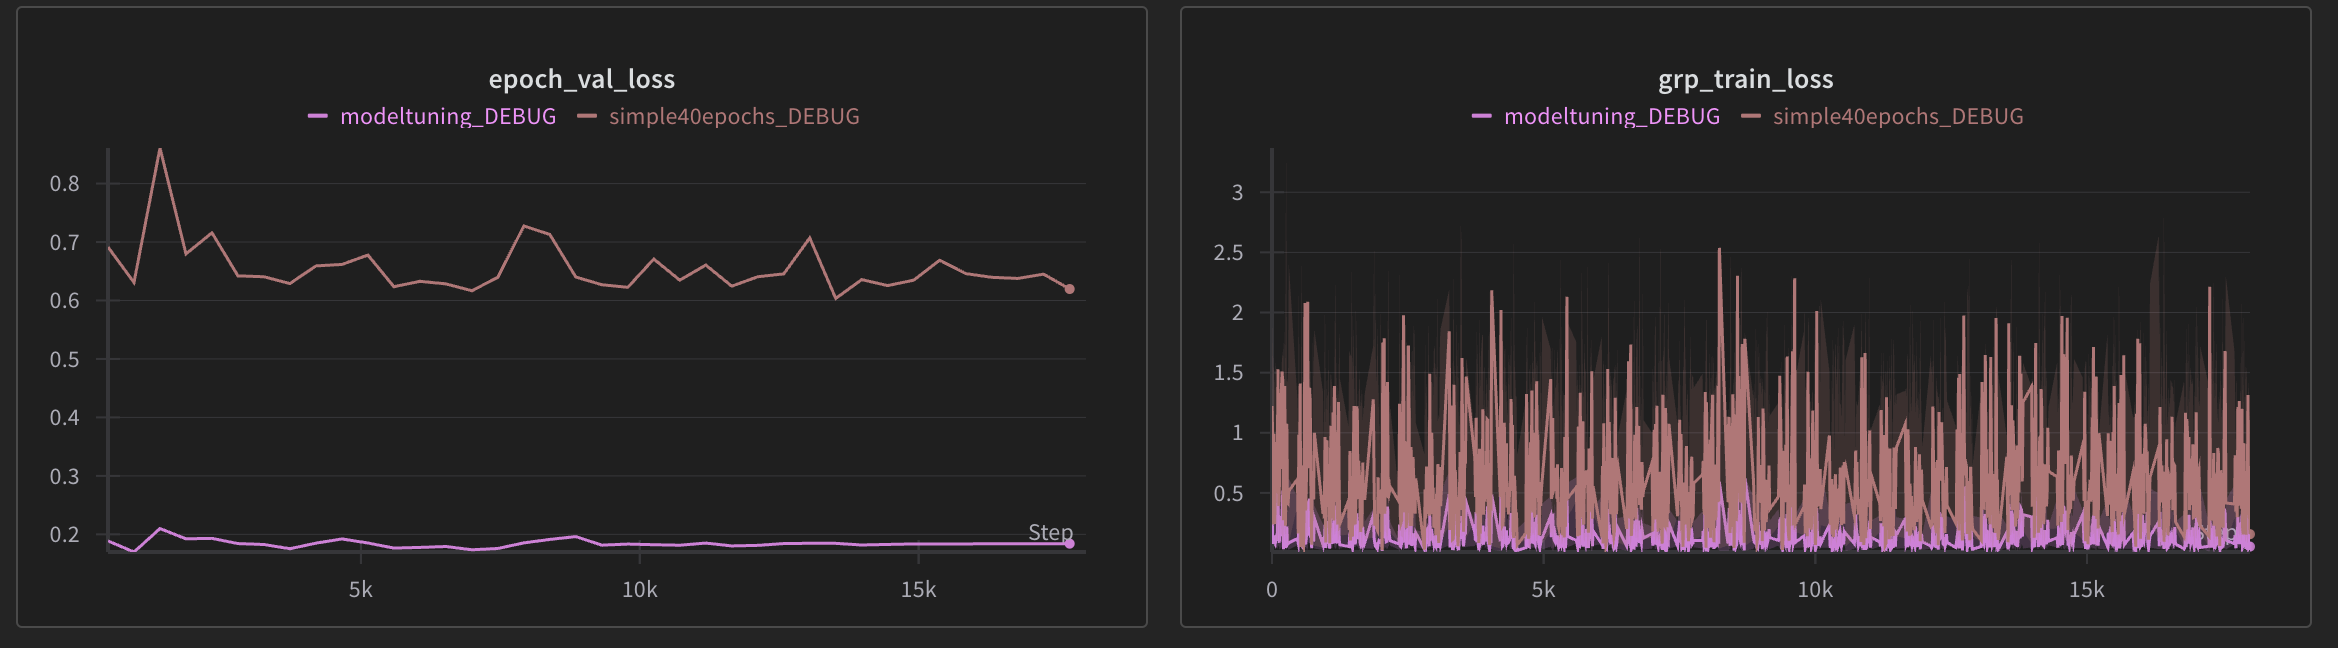

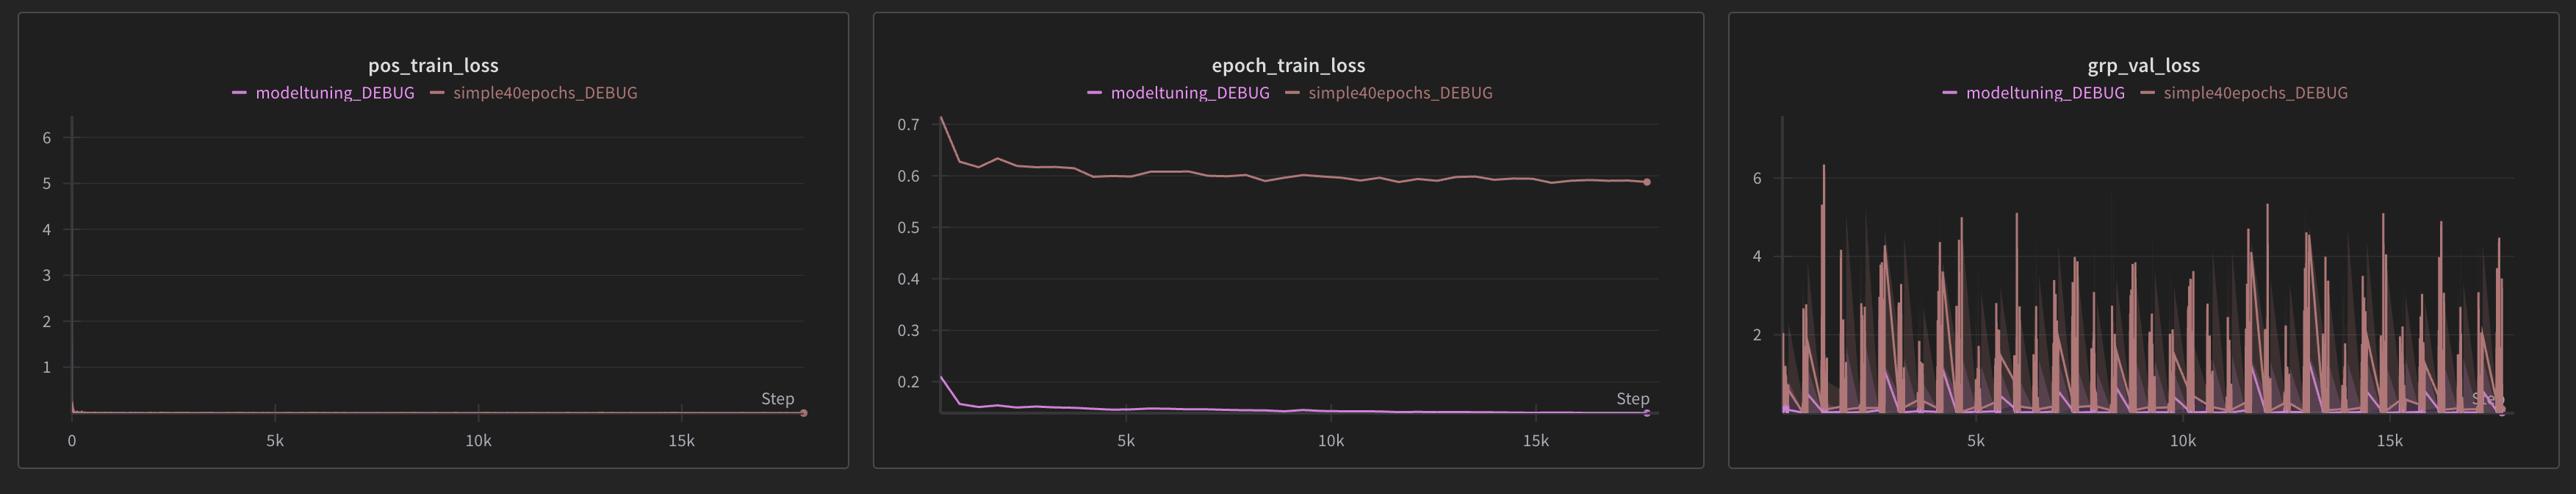

#### Question 1.c.ii Discussion (marks broken down in subsections below)

##### Task
In the markdown blocks below, discuss **three** experiments that you ran during the development of your model, defined in 1.c.i Model tuning which were the **most insightful** with respect to the design of your final model. Importantly, **most insightful** needn't necessarily be the final decisions that appear in the model defined in question 1.c.i Model tuning, rather they should be experiments that most shaped your model development process. For example:
- You might decide to use a learning rate scheduler and decrease the learning rate at epoch 10 (call this experiment "EXP_LR");
- This experiment produces a jump in performance and unlocks a series of further fruitful experiments into learning rate scheduling;
- However, in the model reported in question 1.c.i Model tuning, you use a learning rate schedule with descreases at epochs 6 and 15 (since these produced a marginal performance over "EXP_LR")
- For this question __you should discuss EXP_LR__.
  
For each experiment, complete the "Description", "Result" and "Conclusion" sections where the following information should be provided:
* __Description__: What delta were you measuring i.e., change of architecture, change of learning rate etc?
* __Justification__: **Why** are you conducting the experiment?
  * What was the context of the model development process up to this point? What did you already know about how well the model performed/why it was performing/what were the challenging data points?
* __Conclusion__: What did you __learn__ from the experiment and provide __empirical evidence__ to support this claim. In drawing your conclusions, consider where there are multiple possible causes for the model failing, ensure you provide evidence for each of these and conclude whether or not they might be root cause (you may conclude that there are multiple causes).

**IMPORTANT** If your reported experiments are **not** well motivated and do not demonstrate that you have integrogated the model performance, you will be deducted marks. An example of poor motovation might be: *I chose to decrease the learning rate from X to Y as I did not know what impact this might have*. This justification could be improved by explaining what you __already know__ about how the learning rate might be affecting the model. What hypotheses might you draw about what the experiment will show?



#### Question 1.c.ii.i Experiment 1 discussion (10 marks)



##### Description

Here, I have used a cosine annealing learning rate scheduler. In this learning rate scheduling technique, the learning rate starts at the maximum given values and then decreases using a cosine function over the given number of epochs.

One advantage of cosine annealing is a smoother decay, as seen in the graphs above. The cosine function ensures a smooth and gradual reduction in the learning rate, which helps prevent large drops and enables the model to stabilise.
It also helps to prevent overfitting by lowering the learning rate towards the end of the training.
I have set T_max = 40 for my current setup, meaning the scheduler completes its cycle in 40 epochs.


##### Justification and Conclusion.
The main motivation for using the learning rate scheduler was to solve the instability seen in the training with a fixed learning rate. From previous experiments. Using a fixed learning rate often leads to large oscillations in the loss curves and slower convergence, a learning rate scheduler allows te model to make larger updates early in training and then smaller updates as it starts to converge.

Train and validation loss - With the scheduler, the train loss decreases consistently and more smoothly, with fewer oscillations than the original model. This shows that the learning rate helps the optimiser to converge more efficiently, preventing large updates.
The validation loss stabilises more quickly with the scheduler, which suggests better generalisation.

This addition, however, doesn’t show a significant impact on the grip losses. Hence, an alternate method needs to be used for this class. The position loss shows reduced oscillations and smoothes when the scheduler is used. This would help in precise control tasks, such as robotic arm positioning.

For the evaluation metrics, across the train, validation of precision, recall and F1 scores, the scheduler shows a slight performance improvement, with metrics stabilising more quickly, However, a smaller number of oscillations have been observed, which can highlight improved stability during training.

Overall, the cosine annealing scheduler used in this model effectively balances the exploration and convergence, which helps improve the robustness and generalization of the model. When using a learning rate scheduler, one of the key benefits is a reduction in oscillations seen across all metrics. This suggests that the decay in learning rate helps prevent overcorrection by the optimiser, creating smoother training. Furthermore, by using a scheduler, we observe better generalisation across validation metrics(precision, accuracy, F1), which suggests that the learning rate scheduler helps to generalise unseen data better.
Also, we see better convergence during the later stages of training.


In [7]:
cnn2_config = ConvolutionLayersConfig(
    input_dim=224,
    input_channels=2,
    layers=[
        nn.Conv2d(
            in_channels=2,
            out_channels=8,
            kernel_size=(3,3),
            stride=1,
            padding=1,
            dilation=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))
        ]
    )

_cnn_output_dim = cnn2_config.get_output_dims()
_cnn_output_channels = cnn2_config.get_output_channels()
_mlp_input_dim = int(
            (_cnn_output_dim[-1]*_cnn_output_dim[-1])*_cnn_output_channels[-1]
            )


image_encoder = JointCNNEncoder(
    cnn=CNN(cnn2_config),
    dense=MLP(
        input_dim=_mlp_input_dim,
        hidden_dims=[256],
        output_dim=128
        )
)

obs_encoder = MLP(
    input_dim = 15,
    hidden_dims = [256,256],
    output_dim = 128
)

dense = MLP(
    input_dim = 128,
    hidden_dims = [64,32],
    output_dim = 6
)

class Baseline1(BaseModel):

  def __init__(
      self,
      image_encoder:JointCNNEncoder,
      obs_encoder:MLP,
      dense:MLP
      ) -> None:
      super().__init__()
      self.image_encoder = image_encoder
      self.obs_encoder = obs_encoder
      self.dense = dense

  def forward(self, images, obs):
    _img_enc = self.image_encoder(images)
    _obs_enc = self.obs_encoder(obs)
    _dense_enc = self.dense(_img_enc+_obs_enc)
    pos = _dense_enc[:,0:3]
    grp = _dense_enc[:,3:]
    return {
        "pos": pos,
        "grp":grp
        }
  def reset(
      self,
      image_encoder_kwargs,
      obs_encoder_kwargs,
      dense_kwargs
      ):
    self.image_encoder.reset(**image_encoder_kwargs)
    self.obs_encoder.reset(**obs_encoder_kwargs)
    self.dense.reset(**dense_kwargs)

torch.manual_seed(1)
model = Baseline1(
    image_encoder=image_encoder,
    obs_encoder=obs_encoder,
    dense=dense
)

In [8]:
pos_criterion = nn.MSELoss(reduction="mean")
grp_criterion = nn.CrossEntropyLoss(reduction="mean")

In [9]:
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts


torch.manual_seed(1)
model.reset({},{},{})
exp_kwargs = {
    "batch_size": 64,
    "learning_rate": 0.001,
    "half_precision": True,
    "target_offset": 0
}

if project_options.debug:
    exp_kwargs["batch_size"] = 4

if exp_kwargs["half_precision"]:
    train_dataset = NpDictDataset(
        array_dict=train_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict=val_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )
else:
    train_dataset = NpDictDataset(
        array_dict={k:train_nps[k].astype(np.float32) for k in train_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict={k:val_nps[k].astype(np.float32) for k in val_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

print(len(train_dataset))
out = train_dataset[0]

def collate_func(input_list:List[DatasetOutput])->DatasetOutput:
    pos = []
    _grp = []
    images = []
    obs = []
    for val in input_list:
        images.append(
            torch.concat(
                [val.input["front_cam_ob"], val.input["mount_cam_ob"]],
                dim=0
            )[None,:]
            )
        obs.append(
            torch.concat(
                [
                    val.input["ee_cartesian_pos_ob"],
                    val.input["ee_cartesian_vel_ob"],
                    val.input["joint_pos_ob"]
                    ],
                dim=0
            )[None,:]
        )
        pos.append(val.output["actions"][0:3][None,:])
        _grp.append(val.output["actions"][-1:][None])
    _grp = torch.concat(_grp, dim=0)
    grp = torch.zeros(_grp.shape[0],3)
    grp[torch.arange(len(grp)), _grp.squeeze().int()] = 1
    return DatasetOutput(
        input = {
            "images":torch.concat(images,dim=0),
            "obs":torch.concat(obs,dim=0),
            },
        output = {
            "pos":torch.concat(pos, dim=0),
            "grp":grp
            }
    )


train_dataloader = DataLoader(
    train_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=True,
    collate_fn=collate_func,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=False,
    collate_fn=collate_func,
)

first_batch = next(train_dataloader.__iter__())

input_dim = first_batch.input["images"].shape
print(input_dim)
input_dim = first_batch.input["obs"].shape
print(input_dim)
pos_dim = first_batch.output["pos"].shape
print(pos_dim)
grp_dim = first_batch.output["grp"].shape
print(grp_dim)

exp_kwargs["model_def"] = model.__repr__()


if exp_kwargs["half_precision"]:
    model = model.half()  # Convert model to half-precision

    # Iterate through the model's layers and cast biases to float16 if they are not already
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):  # Check for convolutional and linear layers
            if module.bias is not None and module.bias.dtype != torch.float16:
                module.bias = module.bias.half()  # Cast bias to float16
else:
    # Ensure model is in full precision (float32) if half_precision is False
    model = model.float()  # Convert model to full precision if using FP32

    # Iterate through the model's layers and cast biases to float32
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            if module.bias is not None and module.bias.dtype != torch.float32:
                module.bias = module.bias.float()


optimizer = torch.optim.Adam(
    model.parameters(), lr=exp_kwargs["learning_rate"],
    eps=1e-04
    )

scheduler = CosineAnnealingLR(optimizer, T_max=40, eta_min=1e-7)  # T_max is the number of epochs to restart, adjust as needed.

__criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":pos_criterion,
        "grp": grp_criterion
    }
    )

if exp_kwargs["half_precision"]:
    with torch.no_grad():
        if torch.cuda.is_available():
            model = model.cuda()
            with torch.autocast(device_type="cuda"):
                res = model(
                    images=first_batch.input["images"].cuda(),
                    obs=first_batch.input["obs"].cuda()
                    )
                first_batch.output["pos"] = first_batch.output["pos"].cuda()
                first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            with torch.autocast(device_type="cpu"):
                res = model(
                    images=first_batch.input["images"],
                    obs=first_batch.input["obs"]
                    )
else:
    with torch.no_grad():
        if torch.cuda.is_available():
            model = model.cuda()
            res = model(
                images=first_batch.input["images"].cuda(),
                obs=first_batch.input["obs"].cuda()
                )
            first_batch.output["pos"] = first_batch.output["pos"].cuda()
            first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            res = model(
                images=first_batch.input["images"],
                obs=first_batch.input["obs"]
                )
print(__criterion(res,first_batch.output))



1274
torch.Size([4, 2, 224, 224])
torch.Size([4, 15])
torch.Size([4, 3])
torch.Size([4, 3])
tensor(1.7529, device='cuda:0', dtype=torch.float16)


In [10]:
import copy
import datetime
import wandb

# Initialize metric orchestrator for logging
mo = WandBMetricOrchestrator()

# Define training loss
train_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos": copy.deepcopy(pos_criterion),  # Deep copy of position criterion
        "grp": copy.deepcopy(grp_criterion),  # Deep copy of grip criterion
    },
    name="train",  # Specify that this is for training
    mo=mo  # Pass metric orchestrator
)

# Define validation loss
val_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos": copy.deepcopy(pos_criterion),  # Deep copy of position criterion
        "grp": copy.deepcopy(grp_criterion),  # Deep copy of grip criterion
    },
    name="val",  # Specify that this is for validation
    mo=mo  # Pass metric orchestrator
)

# Initialize the training loop
sl_trainer = TorchTrainingLoop(
    model=model,
    gpu=True,  # Use GPU for training
    optimizer=optimizer,
    criterion=train_criterion,
    val_criterion=val_criterion,
    epochs=40,  # Set the number of epochs
    logger=logger,
    mo=WandBMetricOrchestrator(),
    scheduler=scheduler,
    half_precision=exp_kwargs["half_precision"],  # Use half precision if specified
    preds_save_type=None,  # No predictions saved
    enable_grad_clipping = True
)

# Define Weights & Biases configuration
wandb_name = "scheduler"  # Experiment name
wandb_grp = "End_to_end"  # Experiment group

# Modify name if in debug mode
if project_options.debug:
    wandb_name = f"{wandb_name}_DEBUG"

# Record start time
orig = datetime.datetime.now()

# Start the training loop
sl_trainer.training_loop(
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    wandb_proj=WANDB_PROJECT,
    wandb_grp=wandb_grp,
    wandb_config=exp_kwargs,
    wandb_name=wandb_name,
    reset_kwargs={
        "image_encoder_kwargs": {},  # Reset image encoder arguments
        "obs_encoder_kwargs": {},  # Reset observation encoder arguments
        "dense_kwargs": {}  # Reset dense layer arguments
    }
)

# Record post-training time
post_train = datetime.datetime.now()

# Finish the Weights & Biases run
wandb.finish()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dionfernandes5 (dionfernandes5-university-college-london-ucl-). Use `wandb login --relogin` to force relogin


INFO:cw2_logger:Running epochs: 40
INFO:cw2_logger:Running training epoch
100%|██████████| 319/319 [00:09<00:00, 32.67it/s]
INFO:cw2_logger:Epoch 1	 Training Loss: 0.78857421875	Accuracy: 0.6845	 Precision: 0.6818	Recall: 0.6845	 F1: 0.6693
INFO:cw2_logger:Epoch 1	 Validation Loss: 0.681640625	Accuracy: 0.7676	 Precision: 0.6558	Recall: 0.7676	 F1: 0.7071
INFO:cw2_logger:Epoch 1, Current Learning Rate: 0.0009984588209998775
INFO:cw2_logger:Running training epoch
100%|██████████| 319/319 [00:09<00:00, 32.26it/s]
INFO:cw2_logger:Epoch 2	 Training Loss: 0.6328125	Accuracy: 0.7363	 Precision: 0.6893	Recall: 0.7363	 F1: 0.6385
INFO:cw2_logger:Epoch 2	 Validation Loss: 0.638671875	Accuracy: 0.7797	 Precision: 0.6079	Recall: 0.7797	 F1: 0.6832
INFO:cw2_logger:Epoch 2, Current Learning Rate: 0.0009938447858805393
INFO:cw2_logger:Running training epoch
100%|██████████| 319/319 [00:09<00:00, 32.64it/s]
INFO:cw2_logger:Epoch 3	 Training Loss: 0.626953125	Accuracy: 0.6868	 Precision: 0.5869	Recall

Justification

image.png

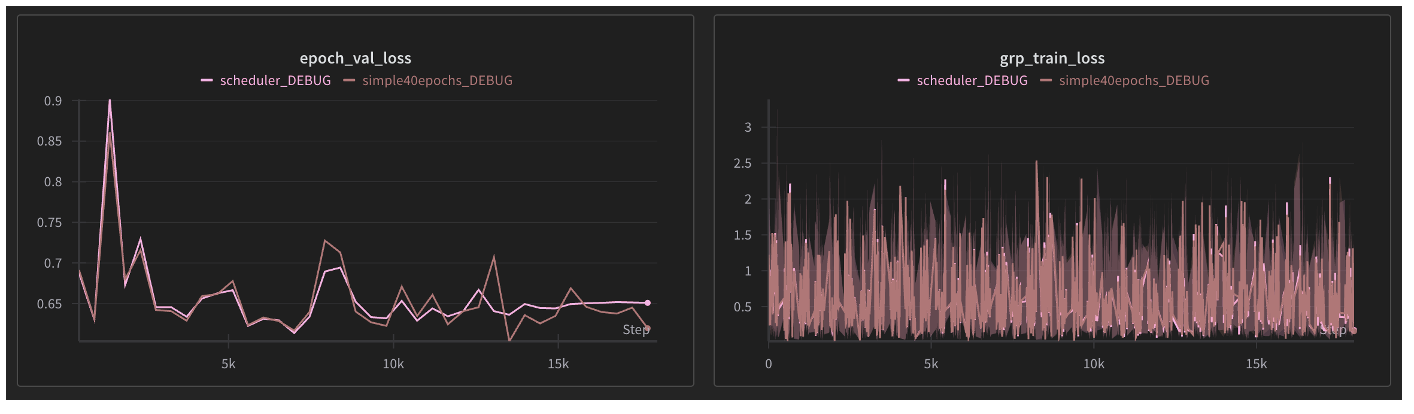

#### Question 1.c.ii.ii Experiment 2 discussion (10 marks)

##### Description
For this improvement, I am lowering the learning rate to 0.0002 to get smoother convergence and fewer oscillations in training and validation metrics.


##### Justification
The experiment was conducted in the context of prior observations:

Observation: With a higher or fixed learning rate, the model exhibited significant oscillations in metrics like precision, recall, and F1 score during training. This indicated potential instability in weight updates, particularly as the model approached convergence.
Hypothesis: Reducing the learning rate mid-training would enable the model to refine weight updates more effectively, avoiding overshooting minima and stabilizing performance metrics. The adjustment at epoch 10 was chosen based on prior insights that most instability occurred in the early stages of training.
Challenging data points, such as grip actions, were less affected by previous optimization strategies. By fine-tuning the learning rate for positional actions, this experiment aimed to isolate grip-related challenges and refine positional learning.



##### Conclusion
With the learning rate improvement, the most significant improvement is shown in the epoch train loss, where the train loss shows a considerable reduction halfway through training. This suggests that a lower learning rate allows the model to make more controlled weight updates, leading to smoother graphs and a more effective optimisation process. This leads to the model converging with fewer oscillations.

The validation recall is more stable and shows fewer oscillations than the original model. This suggests that the lower learning rate allows the model to converge more steadily and ensures that the model avoids large updates to the weights. Furthermore, the lower learning rate also reduces the noise.

The F1 score improves steadily and becomes more stable in fewer epochs than the original model, which showed large fluctuations. The lower learning rate leads to more consistency in improvement for precision and recall, which contributes to a better F1 score.
The grip train and validation loss show no major changes; hence, lowering the earning rate doesn’t improve the performance of the grip class.

Lowering the learning rate leads to few oscillations, and the model becomes stable in fewer epochs. This occurs in all the above evaluation metrics except for the grip metrics. This suggests major improvements in the ability to learn and generalise positional actions effectively; however, a different optimisation strategy is required due to grip-related performance being unaffected.



This experiment validates the hypothesis that learning rate scheduling can unlock better model performance and convergence by reducing instability in the optimization process. The empirical evidence strongly supports the inclusion of a learning rate reduction strategy, particularly for addressing positional learning, while further research is needed for grip-related improvements.








In [ ]:
cnn2_config = ConvolutionLayersConfig(
    input_dim=224,
    input_channels=2,
    layers=[
        nn.Conv2d(
            in_channels=2,
            out_channels=8,
            kernel_size=(3,3),
            stride=1,
            padding=1,
            dilation=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))
        ]
    )

_cnn_output_dim = cnn2_config.get_output_dims()
_cnn_output_channels = cnn2_config.get_output_channels()
_mlp_input_dim = int(
            (_cnn_output_dim[-1]*_cnn_output_dim[-1])*_cnn_output_channels[-1]
            )


image_encoder = JointCNNEncoder(
    cnn=CNN(cnn2_config),
    dense=MLP(
        input_dim=_mlp_input_dim,
        hidden_dims=[256],
        output_dim=128
        )
)

obs_encoder = MLP(
    input_dim = 15,
    hidden_dims = [256,256],
    output_dim = 128
)

dense = MLP(
    input_dim = 128,
    hidden_dims = [64,32],
    output_dim = 6
)

class Baseline1(BaseModel):

  def __init__(
      self,
      image_encoder:JointCNNEncoder,
      obs_encoder:MLP,
      dense:MLP
      ) -> None:
      super().__init__()
      self.image_encoder = image_encoder
      self.obs_encoder = obs_encoder
      self.dense = dense

  def forward(self, images, obs):
    _img_enc = self.image_encoder(images)
    _obs_enc = self.obs_encoder(obs)
    _dense_enc = self.dense(_img_enc+_obs_enc)
    pos = _dense_enc[:,0:3]
    grp = _dense_enc[:,3:]
    return {
        "pos": pos,
        "grp":grp
        }
  def reset(
      self,
      image_encoder_kwargs,
      obs_encoder_kwargs,
      dense_kwargs
      ):
    self.image_encoder.reset(**image_encoder_kwargs)
    self.obs_encoder.reset(**obs_encoder_kwargs)
    self.dense.reset(**dense_kwargs)

torch.manual_seed(1)
model = Baseline1(
    image_encoder=image_encoder,
    obs_encoder=obs_encoder,
    dense=dense
)

In [ ]:

pos_criterion = nn.MSELoss(reduction="mean")
grp_criterion = nn.CrossEntropyLoss(reduction="mean")

In [ ]:
torch.manual_seed(1)
model.reset({},{},{})
exp_kwargs = {
    "batch_size": 64,
    "learning_rate": 0.0002,
    "half_precision": True,
    "target_offset": 0
}

if project_options.debug:
    exp_kwargs["batch_size"] = 4

if exp_kwargs["half_precision"]:
    train_dataset = NpDictDataset(
        array_dict=train_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict=val_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )
else:
    train_dataset = NpDictDataset(
        array_dict={k:train_nps[k].astype(np.float32) for k in train_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict={k:val_nps[k].astype(np.float32) for k in val_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

print(len(train_dataset))
out = train_dataset[0]

def collate_func(input_list:List[DatasetOutput])->DatasetOutput:
    pos = []
    _grp = []
    images = []
    obs = []
    for val in input_list:
        images.append(
            torch.concat(
                [val.input["front_cam_ob"], val.input["mount_cam_ob"]],
                dim=0
            )[None,:]
            )
        obs.append(
            torch.concat(
                [
                    val.input["ee_cartesian_pos_ob"],
                    val.input["ee_cartesian_vel_ob"],
                    val.input["joint_pos_ob"]
                    ],
                dim=0
            )[None,:]
        )
        pos.append(val.output["actions"][0:3][None,:])
        _grp.append(val.output["actions"][-1:][None])
    _grp = torch.concat(_grp, dim=0)
    grp = torch.zeros(_grp.shape[0],3)
    grp[torch.arange(len(grp)), _grp.squeeze().int()] = 1
    return DatasetOutput(
        input = {
            "images":torch.concat(images,dim=0),
            "obs":torch.concat(obs,dim=0),
            },
        output = {
            "pos":torch.concat(pos, dim=0),
            "grp":grp
            }
    )


train_dataloader = DataLoader(
    train_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=True,
    collate_fn=collate_func,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=False,
    collate_fn=collate_func,
)

first_batch = next(train_dataloader.__iter__())

input_dim = first_batch.input["images"].shape
print(input_dim)
input_dim = first_batch.input["obs"].shape
print(input_dim)
pos_dim = first_batch.output["pos"].shape
print(pos_dim)
grp_dim = first_batch.output["grp"].shape
print(grp_dim)

exp_kwargs["model_def"] = model.__repr__()


if exp_kwargs["half_precision"]:
    model = model.half()
optimizer = torch.optim.Adam(
    model.parameters(), lr=exp_kwargs["learning_rate"],
    eps=1e-04
    )

__criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":pos_criterion,
        "grp": grp_criterion
    }
    )

if exp_kwargs["half_precision"]:
    with torch.no_grad():
        if torch.cuda.is_available():
            model = model.cuda()
            with torch.autocast(device_type="cuda"):
                res = model(
                    images=first_batch.input["images"].cuda(),
                    obs=first_batch.input["obs"].cuda()
                    )
                first_batch.output["pos"] = first_batch.output["pos"].cuda()
                first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            with torch.autocast(device_type="cpu"):
                res = model(
                    images=first_batch.input["images"],
                    obs=first_batch.input["obs"]
                    )
else:
    with torch.no_grad():
        if torch.cuda.is_available():
            model = model.cuda()
            res = model(
                images=first_batch.input["images"].cuda(),
                obs=first_batch.input["obs"].cuda()
                )
            first_batch.output["pos"] = first_batch.output["pos"].cuda()
            first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            res = model(
                images=first_batch.input["images"],
                obs=first_batch.input["obs"]
                )
print(__criterion(res,first_batch.output))


1274
torch.Size([4, 2, 224, 224])
torch.Size([4, 15])
torch.Size([4, 3])
torch.Size([4, 3])
tensor(1.7529, device='cuda:0', dtype=torch.float16)


In [ ]:
import wandb

mo = WandBMetricOrchestrator()
train_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="train",
    mo=mo
    )

val_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="val",
    mo=mo
    )

sl_trainer = TorchTrainingLoop(
    model=model, gpu=True, optimizer=optimizer, criterion=train_criterion,
    val_criterion=val_criterion, epochs=40, logger=logger, scheduler=None,
    mo=WandBMetricOrchestrator(), half_precision=exp_kwargs["half_precision"],
    preds_save_type=None, enable_grad_clipping = True
)

wandb_name = f"learningrt0.0002"
wandb_grp="End_to_end"

if project_options.debug:
    wandb_name = f"{wandb_name}_DEBUG"


orig = datetime.datetime.now()
sl_trainer.training_loop(
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    wandb_proj=WANDB_PROJECT,
    wandb_grp=wandb_grp,
    wandb_config=exp_kwargs,
    wandb_name=wandb_name,
    reset_kwargs={
        "image_encoder_kwargs": {},
        "obs_encoder_kwargs": {},
        "dense_kwargs": {}
    }
    )
post_train = datetime.datetime.now()
wandb.finish()

wandb: Currently logged in as: dionfernandes5 (dionfernandes5-university-college-london-ucl-). Use `wandb login --relogin` to force relogin


INFO:cw2_logger:Running epochs: 40
INFO:cw2_logger:Running training epoch
100%|██████████| 319/319 [00:09<00:00, 32.29it/s]
INFO:cw2_logger:Epoch 1	 Training Loss: 0.6640625	Accuracy: 0.7025	 Precision: 0.7581	Recall: 0.7025	 F1: 0.7011
INFO:cw2_logger:Epoch 1	 Validation Loss: 0.66845703125	Accuracy: 0.7762	 Precision: 0.7738	Recall: 0.7762	 F1: 0.7602
INFO:cw2_logger:Scheduler is None or not initialized.
INFO:cw2_logger:Running training epoch
100%|██████████| 319/319 [00:09<00:00, 32.01it/s]
INFO:cw2_logger:Epoch 2	 Training Loss: 0.6171875	Accuracy: 0.7520	 Precision: 0.7425	Recall: 0.7520	 F1: 0.6839
INFO:cw2_logger:Epoch 2	 Validation Loss: 0.634765625	Accuracy: 0.7935	 Precision: 0.7890	Recall: 0.7935	 F1: 0.7299
INFO:cw2_logger:Scheduler is None or not initialized.
INFO:cw2_logger:Running training epoch
100%|██████████| 319/319 [00:09<00:00, 33.13it/s]
INFO:cw2_logger:Epoch 3	 Training Loss: 0.59521484375	Accuracy: 0.7480	 Precision: 0.7633	Recall: 0.7480	 F1: 0.7266
INFO:cw2_lo

image.png

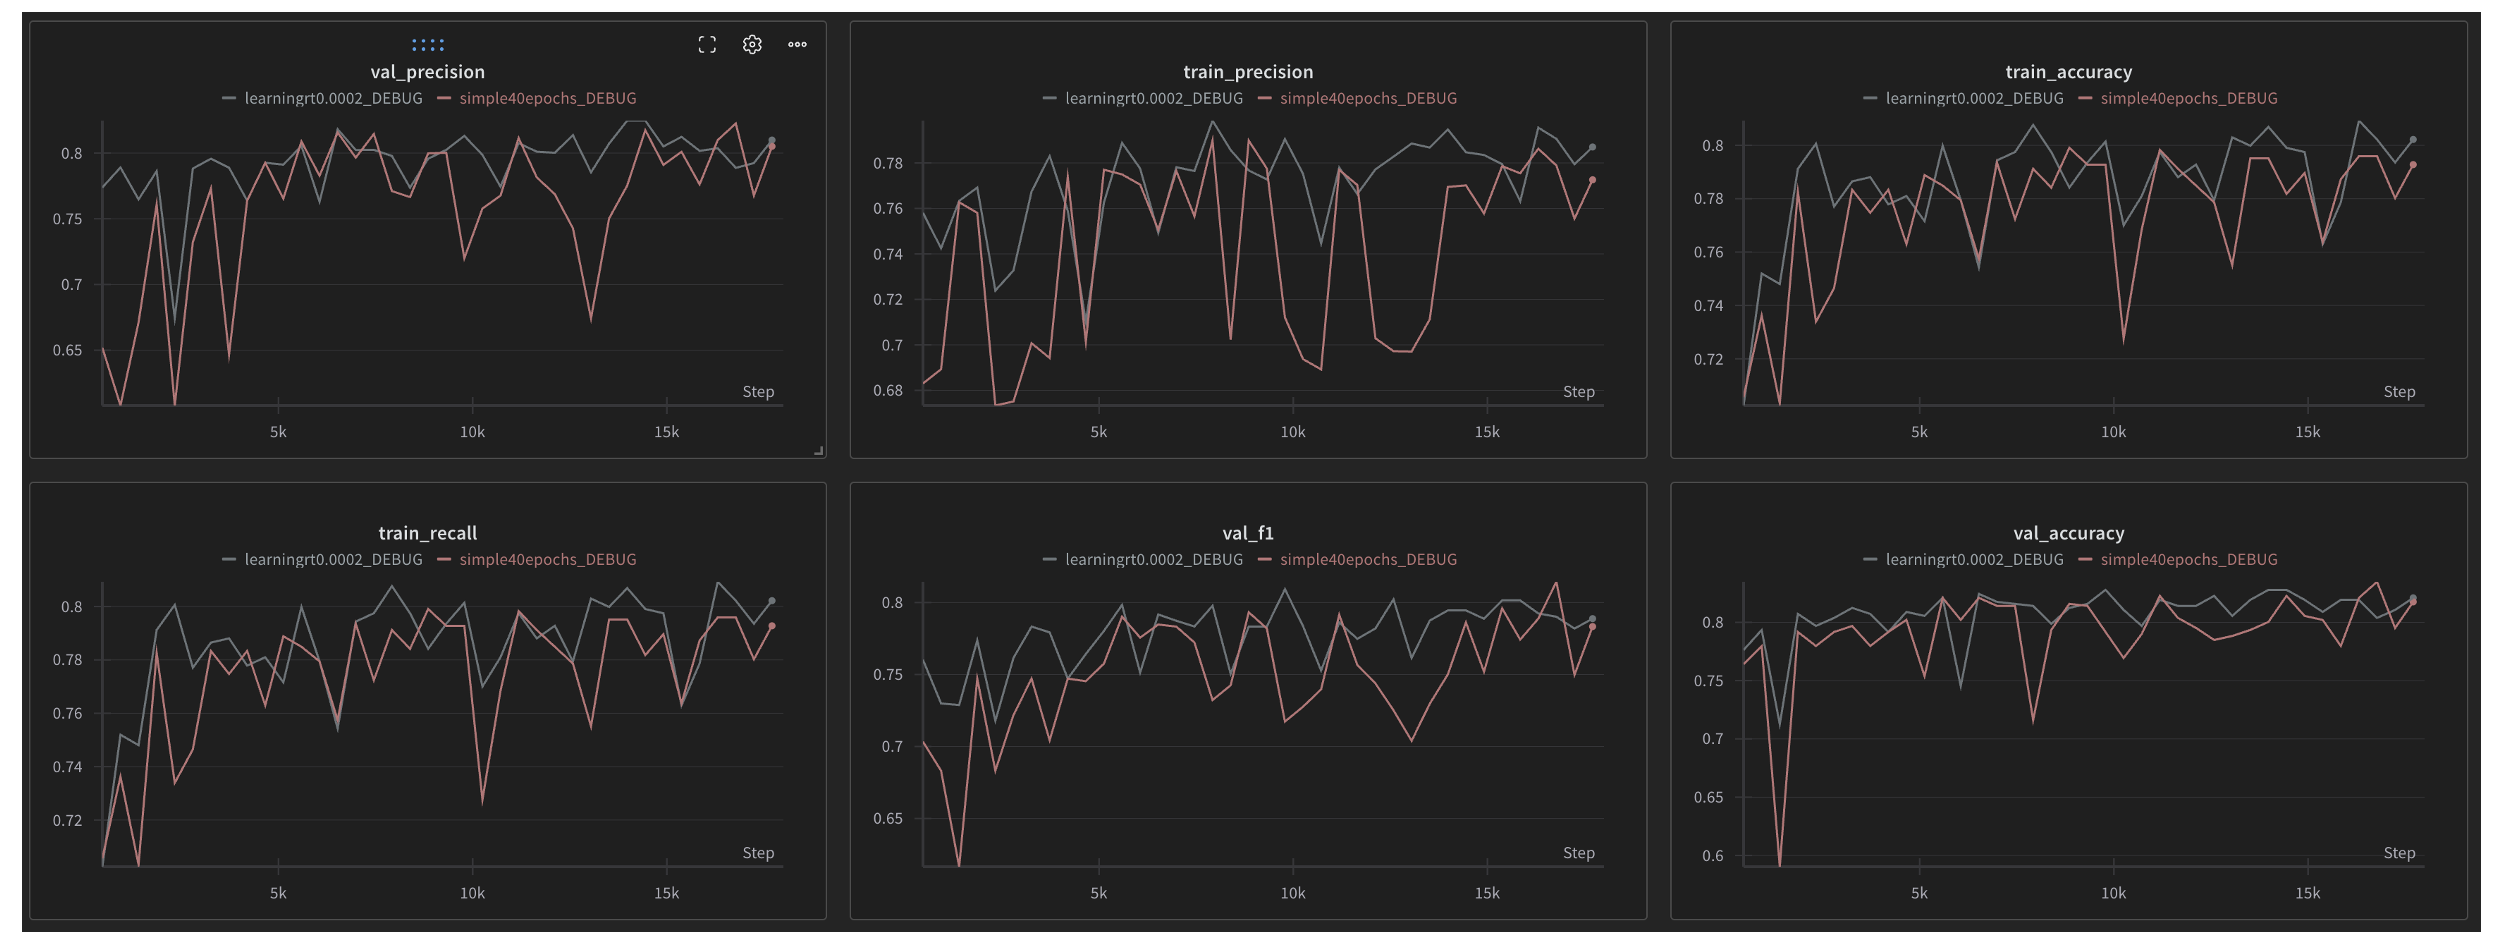

#### Question 1.c.ii.iii Experiment 3 discussion (10 marks)

##### Description
The improvement is about class weighting to address the issue of imbalanced data in the grip labels. I have observed an imbalance by analysing the class counts of the grip labels. To solve this, I have calculated the class weights and applied approximate weights to the cross entropy function. This helps to reduce the impact of dominant classes and enhance the performance of minority classes.



##### Justification
Grip validation and training losses show a significant decrease, suggesting that the application of class weighting has successfully led the model to better focus on underrepresented grip classes. Furthermore, there is a significant decrease in the training and validation loss caused by the lowered grip losses.

Apart from the training precision, all the evaluation metrics show reduced oscillations, suggesting that the model's optimisation process has become more stable and consistent. This indicates improved convergence behaviour, likely due to the mitigation of imbalances in the dataset through class weighting, allowing the model to learn more effectively and generalise better across all classes.


##### Conclusion
Overall, class weighing helped to reduce bias towards the most frequently gripped class, which led to improved recall and precision for the minority class. The significant decrease in the training and validation losses from the overall total and the grip class suggests that we have solved the root cause of the loss we observed.

In [ ]:
cnn2_config = ConvolutionLayersConfig(
    input_dim=224,
    input_channels=2,
    layers=[
        nn.Conv2d(
            in_channels=2,
            out_channels=8,
            kernel_size=(3,3),
            stride=1,
            padding=1,
            dilation=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))
        ]
    )

_cnn_output_dim = cnn2_config.get_output_dims()
_cnn_output_channels = cnn2_config.get_output_channels()
_mlp_input_dim = int(
            (_cnn_output_dim[-1]*_cnn_output_dim[-1])*_cnn_output_channels[-1]
            )


image_encoder = JointCNNEncoder(
    cnn=CNN(cnn2_config),
    dense=MLP(
        input_dim=_mlp_input_dim,
        hidden_dims=[256],
        output_dim=128
        )
)

obs_encoder = MLP(
    input_dim = 15,
    hidden_dims = [256,256],
    output_dim = 128
)

dense = MLP(
    input_dim = 128,
    hidden_dims = [64,32],
    output_dim = 6
)

class Baseline1(BaseModel):

  def __init__(
      self,
      image_encoder:JointCNNEncoder,
      obs_encoder:MLP,
      dense:MLP
      ) -> None:
      super().__init__()
      self.image_encoder = image_encoder
      self.obs_encoder = obs_encoder
      self.dense = dense

  def forward(self, images, obs):
    _img_enc = self.image_encoder(images)
    _obs_enc = self.obs_encoder(obs)
    _dense_enc = self.dense(_img_enc+_obs_enc)
    pos = _dense_enc[:,0:3]
    grp = _dense_enc[:,3:]
    return {
        "pos": pos,
        "grp":grp
        }
  def reset(
      self,
      image_encoder_kwargs,
      obs_encoder_kwargs,
      dense_kwargs
      ):
    self.image_encoder.reset(**image_encoder_kwargs)
    self.obs_encoder.reset(**obs_encoder_kwargs)
    self.dense.reset(**dense_kwargs)

torch.manual_seed(1)
model = Baseline1(
    image_encoder=image_encoder,
    obs_encoder=obs_encoder,
    dense=dense
)

In [ ]:
# import numpy as np

# Assuming 'actions' contains the grip labels in the last column
grp_labels = train_nps["actions"][:, -1]  # Extract grip labels

# Convert grp_labels to integers before using np.bincount
grp_labels = grp_labels.astype(int)

class_counts = np.bincount(grp_labels)   # Count occurrences of each class
print(f"Class counts: {class_counts}")


pos_criterion = nn.MSELoss(reduction="mean")
# grp_criterion = nn.CrossEntropyLoss(reduction="mean")

grp_class_weights = torch.tensor([0.5, 0.2, 0.3]).cuda()  # Replace w1, w2, w3 with appropriate class weights
grp_criterion = nn.CrossEntropyLoss(weight=grp_class_weights, reduction="mean")



from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts

torch.manual_seed(1)
model.reset({},{},{})
exp_kwargs = {
    "batch_size": 64,
    "learning_rate": 0.001,
    "half_precision": True,
    "target_offset": 0
}

if project_options.debug:
    exp_kwargs["batch_size"] = 4

if exp_kwargs["half_precision"]:
    train_dataset = NpDictDataset(
        array_dict=train_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict=val_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )
else:
    train_dataset = NpDictDataset(
        array_dict={k:train_nps[k].astype(np.float32) for k in train_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict={k:val_nps[k].astype(np.float32) for k in val_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

print(len(train_dataset))
out = train_dataset[0]

def collate_func(input_list:List[DatasetOutput])->DatasetOutput:
    pos = []
    _grp = []
    images = []
    obs = []
    for val in input_list:
        images.append(
            torch.concat(
                [val.input["front_cam_ob"], val.input["mount_cam_ob"]],
                dim=0
            )[None,:]
            )
        obs.append(
            torch.concat(
                [
                    val.input["ee_cartesian_pos_ob"],
                    val.input["ee_cartesian_vel_ob"],
                    val.input["joint_pos_ob"]
                    ],
                dim=0
            )[None,:]
        )
        pos.append(val.output["actions"][0:3][None,:])
        _grp.append(val.output["actions"][-1:][None])
    _grp = torch.concat(_grp, dim=0)
    grp = torch.zeros(_grp.shape[0],3)
    grp[torch.arange(len(grp)), _grp.squeeze().int()] = 1
    return DatasetOutput(
        input = {
            "images":torch.concat(images,dim=0),
            "obs":torch.concat(obs,dim=0),
            },
        output = {
            "pos":torch.concat(pos, dim=0),
            "grp":grp
            }
    )


train_dataloader = DataLoader(
    train_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=True,
    collate_fn=collate_func,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=False,
    collate_fn=collate_func,
)

first_batch = next(train_dataloader.__iter__())

input_dim = first_batch.input["images"].shape
print(input_dim)
input_dim = first_batch.input["obs"].shape
print(input_dim)
pos_dim = first_batch.output["pos"].shape
print(pos_dim)
grp_dim = first_batch.output["grp"].shape
print(grp_dim)

exp_kwargs["model_def"] = model.__repr__()


if exp_kwargs["half_precision"]:
    model = model.half()  # Convert model to half-precision

    # Iterate through the model's layers and cast biases to float16 if they are not already
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):  # Check for convolutional and linear layers
            if module.bias is not None and module.bias.dtype != torch.float16:
                module.bias = module.bias.half()  # Cast bias to float16
else:
    # Ensure model is in full precision (float32) if half_precision is False
    model = model.float()  # Convert model to full precision if using FP32

    # Iterate through the model's layers and cast biases to float32
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            if module.bias is not None and module.bias.dtype != torch.float32:
                module.bias = module.bias.float()

optimizer = torch.optim.Adam(
    model.parameters(), lr=exp_kwargs["learning_rate"],
    eps=1e-04
    )



__criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":pos_criterion,
        "grp": grp_criterion
    }
    )

if exp_kwargs["half_precision"]:
    with torch.no_grad():
        if torch.cuda.is_available():
            model = model.cuda()
            with torch.autocast(device_type="cuda"):
                res = model(
                    images=first_batch.input["images"].cuda(),
                    obs=first_batch.input["obs"].cuda()
                    )
                first_batch.output["pos"] = first_batch.output["pos"].cuda()
                first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            with torch.autocast(device_type="cpu"):
                res = model(
                    images=first_batch.input["images"],
                    obs=first_batch.input["obs"]
                    )
else:
    with torch.no_grad():
        if torch.cuda.is_available():
            model = model.cuda()
            res = model(
                images=first_batch.input["images"].cuda(),
                obs=first_batch.input["obs"].cuda()
                )
            first_batch.output["pos"] = first_batch.output["pos"].cuda()
            first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            res = model(
                images=first_batch.input["images"],
                obs=first_batch.input["obs"]
                )
print(__criterion(res,first_batch.output))


Class counts: [129 921 224]
1274
torch.Size([4, 2, 224, 224])
torch.Size([4, 15])
torch.Size([4, 3])
torch.Size([4, 3])
tensor(0.6055, device='cuda:0', dtype=torch.float16)


In [ ]:
import wandb
mo = WandBMetricOrchestrator() #This orchestrator tracks and logs metrics (e.g., loss, accuracy) during training and validation runs to Weights & Biases (WandB).


train_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="train",
    mo=mo
    )

val_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="val",
    mo=mo
    )

sl_trainer = TorchTrainingLoop(
    model=model, gpu=True, optimizer=optimizer, criterion=train_criterion,
    val_criterion=val_criterion, epochs=40, logger=logger, scheduler=None,
    mo=WandBMetricOrchestrator(), half_precision=exp_kwargs["half_precision"],
    preds_save_type=None, enable_grad_clipping = True
)

wandb_name = "weighted_criterion"
wandb_grp="End_to_end"

if project_options.debug:
    wandb_name = f"{wandb_name}_DEBUG"

orig = datetime.datetime.now()
sl_trainer.training_loop(
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    wandb_proj=WANDB_PROJECT,
    wandb_grp=wandb_grp,
    wandb_config=exp_kwargs,
    wandb_name=wandb_name,
    reset_kwargs={
        "image_encoder_kwargs": {},
        "obs_encoder_kwargs": {},
        "dense_kwargs": {}
    }
    )

post_train = datetime.datetime.now()
wandb.finish()

INFO:cw2_logger:Running epochs: 40
INFO:cw2_logger:Running training epoch
100%|██████████| 319/319 [00:09<00:00, 33.05it/s]
INFO:cw2_logger:Epoch 1	 Training Loss: 0.3466796875	Accuracy: 0.5926	 Precision: 0.7620	Recall: 0.5926	 F1: 0.6224
INFO:cw2_logger:Epoch 1	 Validation Loss: 0.227783203125	Accuracy: 0.7281	 Precision: 0.7664	Recall: 0.7281	 F1: 0.7444
INFO:cw2_logger:Scheduler is None or not initialized.
INFO:cw2_logger:Running training epoch
100%|██████████| 319/319 [00:09<00:00, 32.52it/s]
INFO:cw2_logger:Epoch 2	 Training Loss: 0.199462890625	Accuracy: 0.7457	 Precision: 0.7369	Recall: 0.7457	 F1: 0.6883
INFO:cw2_logger:Epoch 2	 Validation Loss: 0.2215576171875	Accuracy: 0.7917	 Precision: 0.7822	Recall: 0.7917	 F1: 0.7324
INFO:cw2_logger:Scheduler is None or not initialized.
INFO:cw2_logger:Running training epoch
100%|██████████| 319/319 [00:09<00:00, 32.62it/s]
INFO:cw2_logger:Epoch 3	 Training Loss: 0.1905517578125	Accuracy: 0.6130	 Precision: 0.7594	Recall: 0.6130	 F1: 0.6

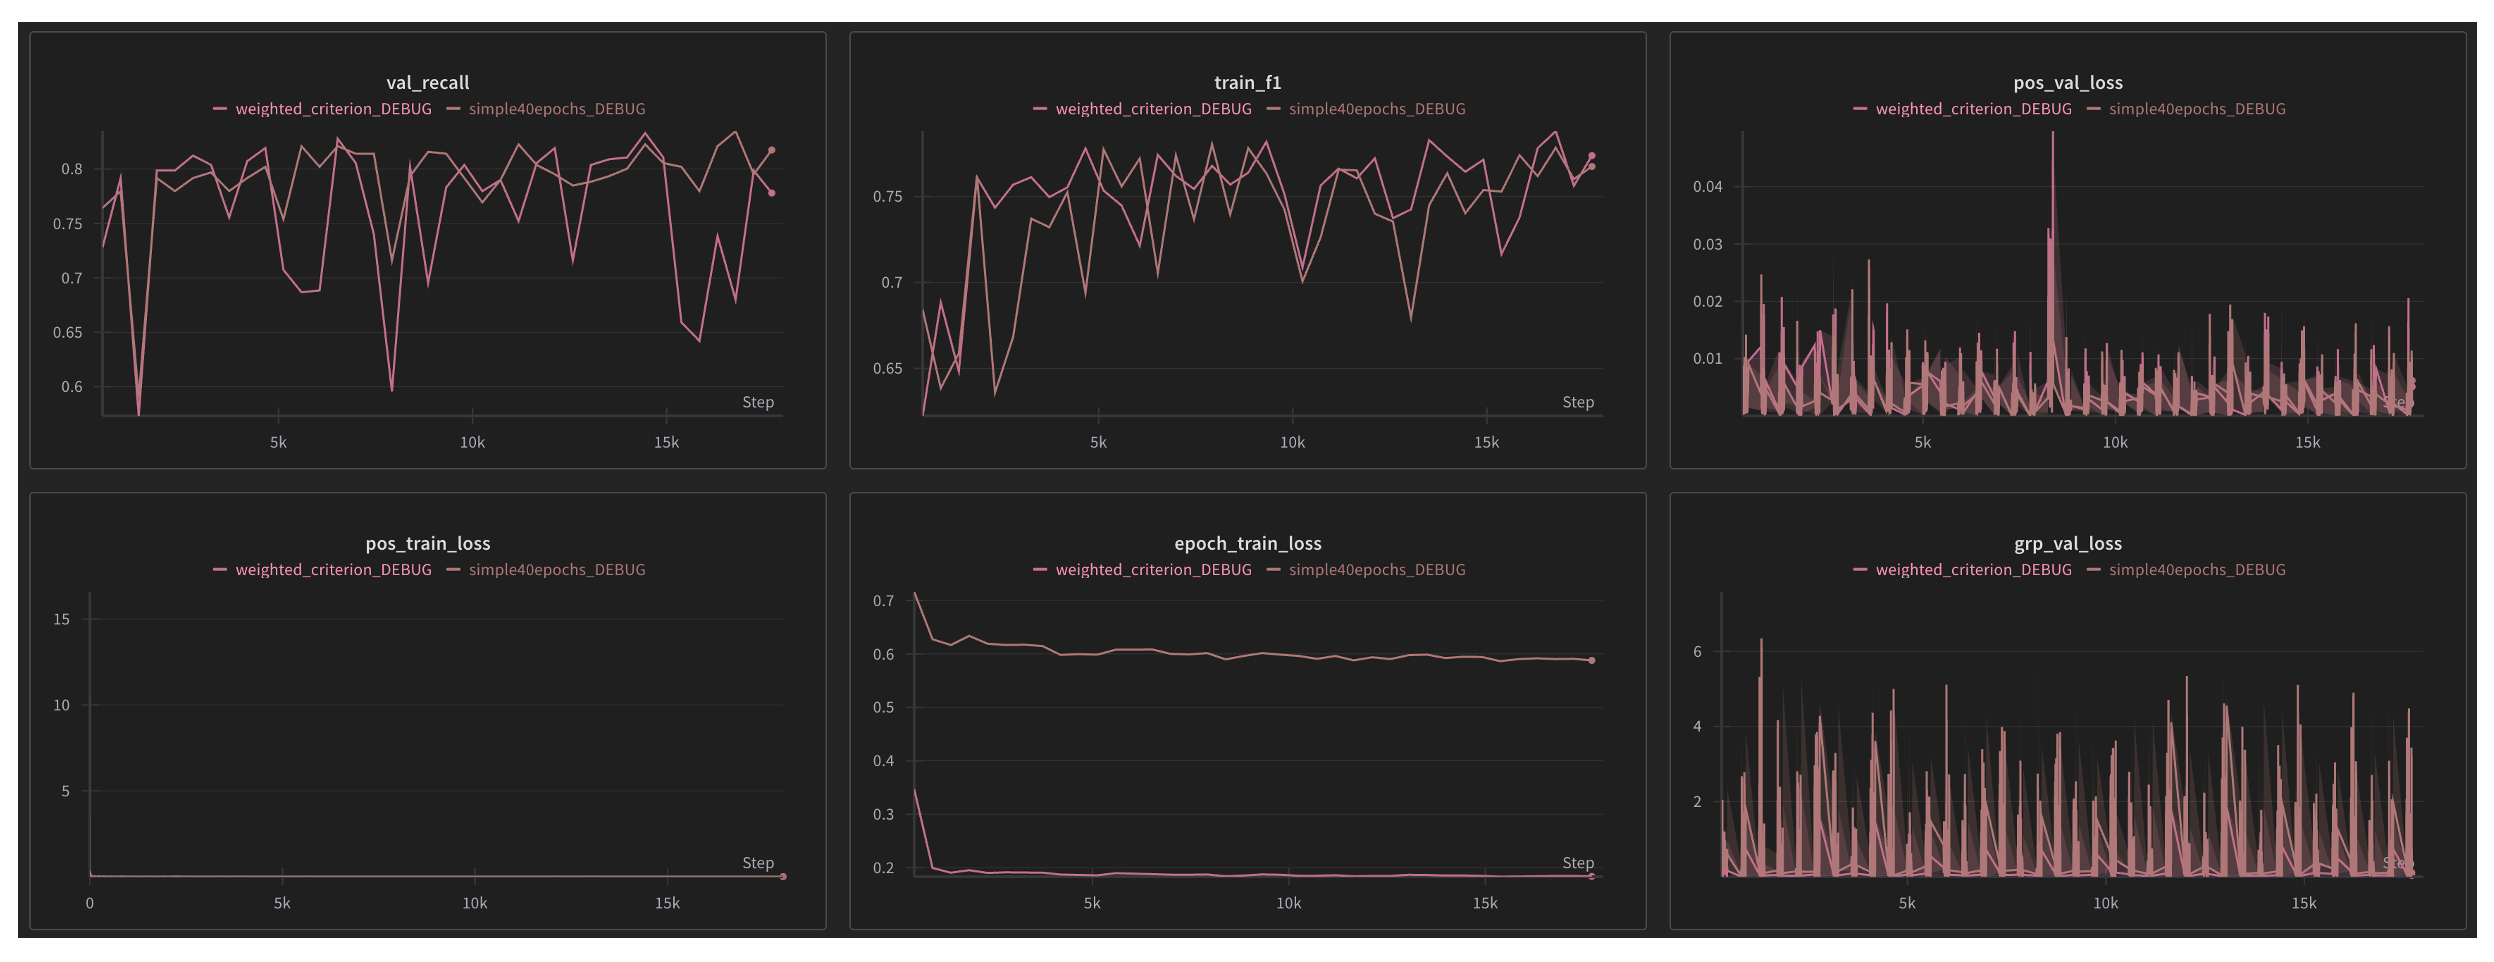


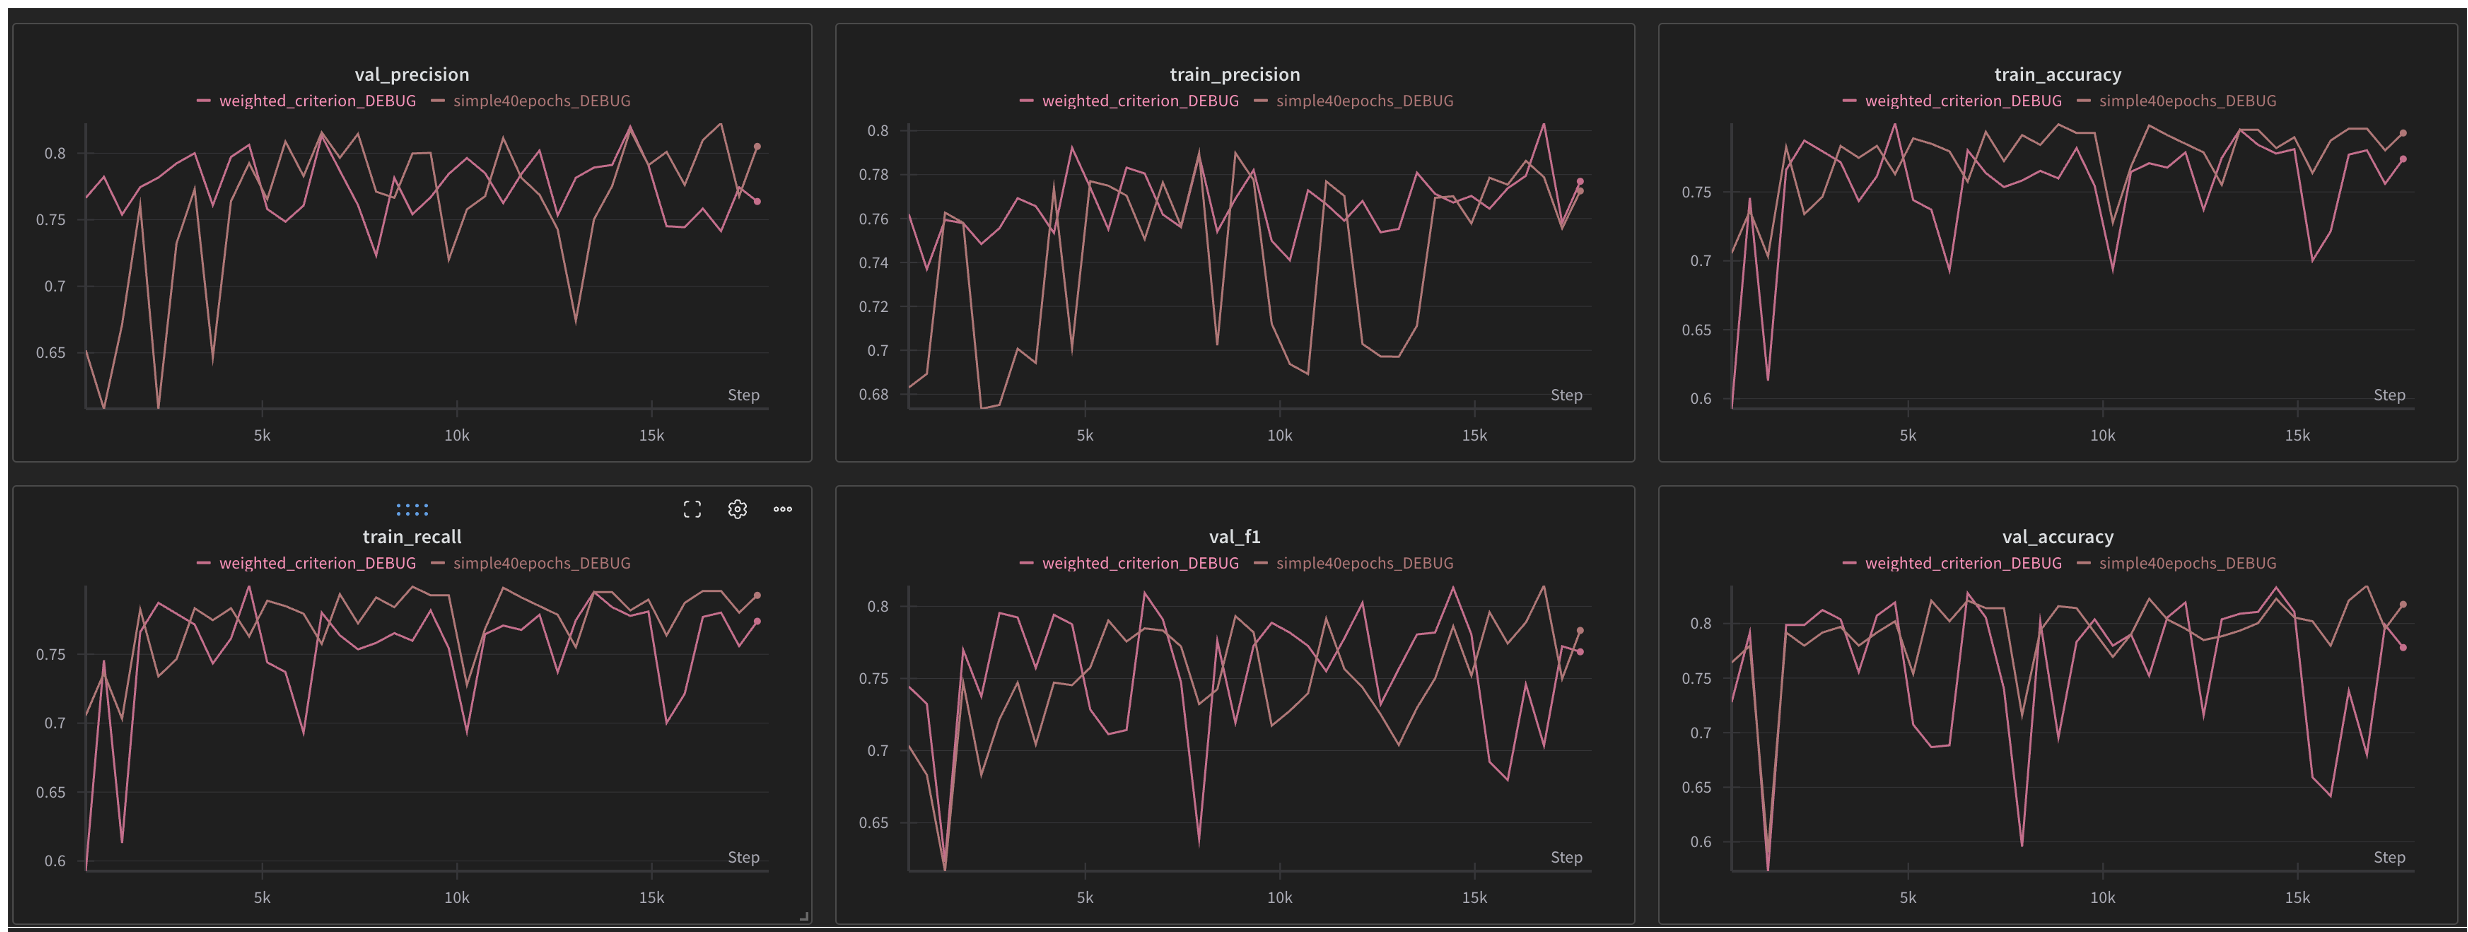


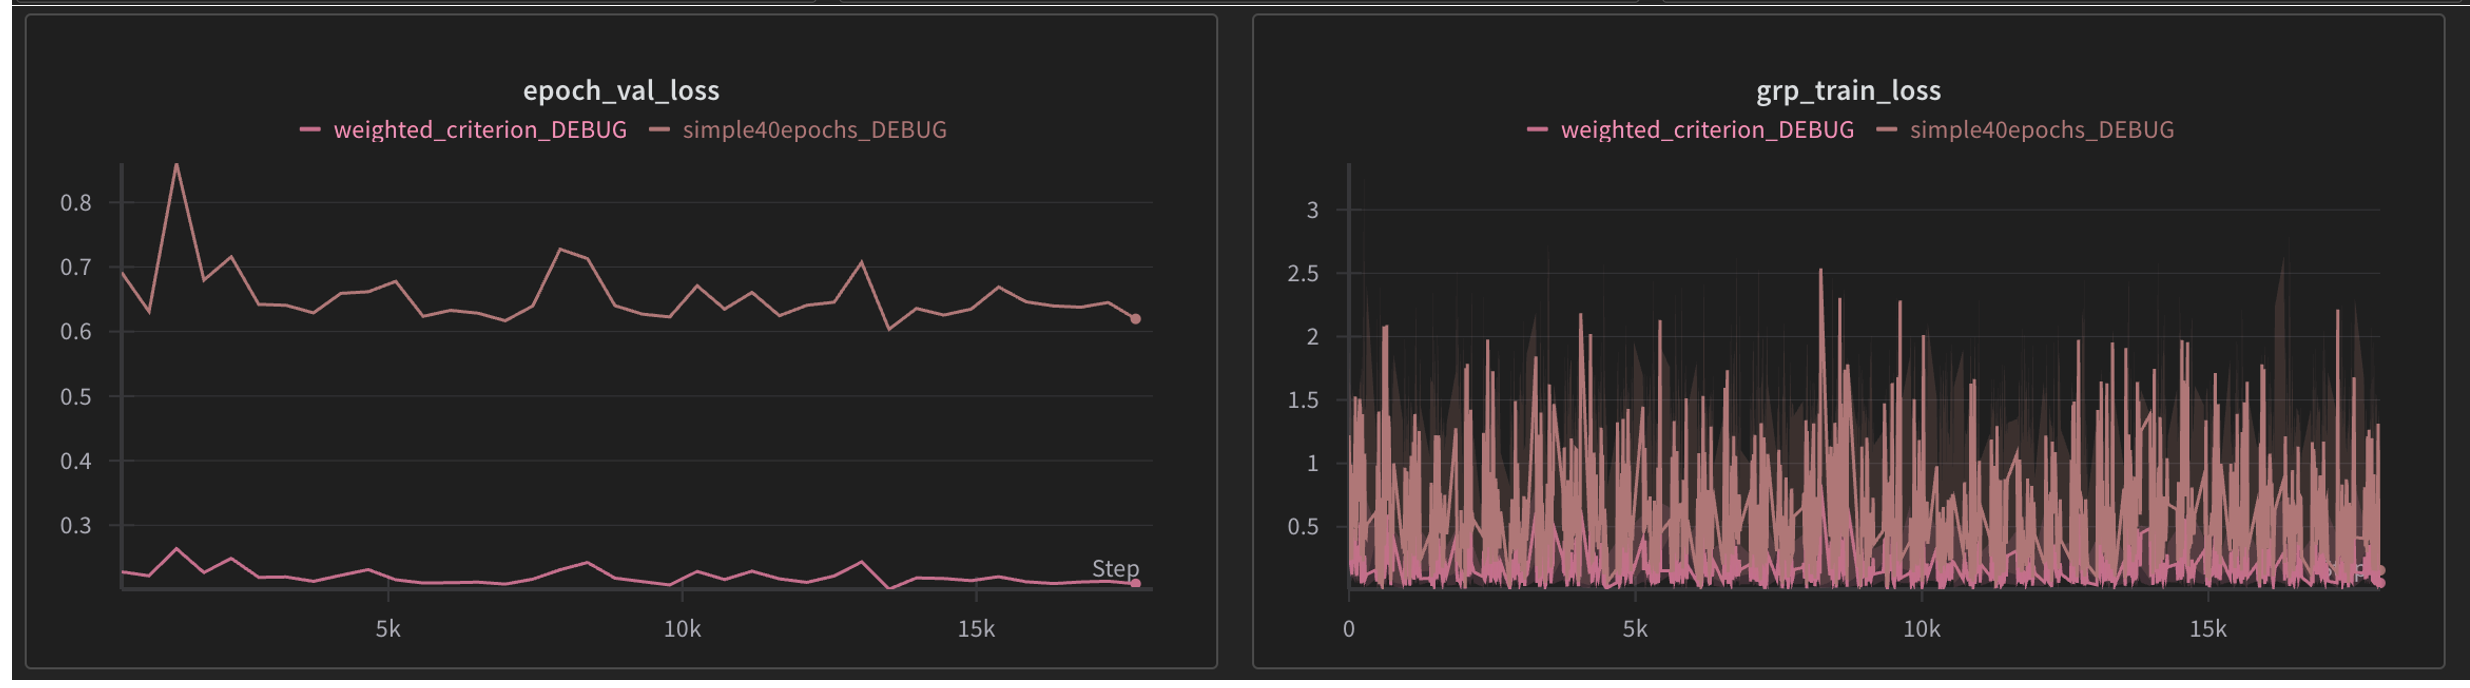

### Question 2 Self-supervised pretraining with VAEs

This question requires you to implement a self-supervised approach using a VAE architecture. The focus of question 2 is in developing a VAE model without using __any__ supervised information i.e., without using any action information. You will assess the convergence of the model and the suitability of the learnt latent space. You are required to select and appropriate architecture/loss function/target set of observations to perform self-supervised learning over.

__IMPORTANT__: Do not use any of the __action__ information. You will be awarded 0 marks if you do.

### Question 2.a Self-supervised VAE model (5 marks)

##### Task
- Implement the full model training process and model definiton in the code block below. Markers should be able to retrain your model by running the cell below. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions).

In [ ]:
# ****** INSERT YOUR CODE HERE ******

from PIL import Image

# Compute mean and standard deviation for normalization
mean_pos = train_nps["ee_cartesian_pos_ob"].mean(axis=0)
std_pos = train_nps["ee_cartesian_pos_ob"].std(axis=0)

mean_vel = train_nps["ee_cartesian_vel_ob"].mean(axis=0)
std_vel = train_nps["ee_cartesian_vel_ob"].std(axis=0)

mean_joint_pos = train_nps["joint_pos_ob"].mean(axis=0)
std_joint_pos = train_nps["joint_pos_ob"].std(axis=0)

# Avoid division by zero
std_pos[std_pos == 0] = 1e-6
std_vel[std_vel == 0] = 1e-6
std_joint_pos[std_joint_pos == 0] = 1e-6

# Define global transformations for inputs
global_transforms = {
    "front_cam_ob": transforms.Compose([
        transforms.Lambda(lambda x: Image.fromarray(x.astype(np.uint8))),  # Convert to PIL Image
        transforms.Resize((224, 224)),
        # transforms.Lambda(lambda x: x.convert("RGB")),  # Convert grayscale to RGB
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
        transforms.Normalize(mean=[0.5], std=[0.5])  # Single-channel mean and std
    ]),

    "mount_cam_ob": transforms.Compose([
        transforms.Lambda(lambda x: Image.fromarray(x.astype(np.uint8))),  # Convert to PIL Image
        transforms.Resize((224, 224)),
        # transforms.Lambda(lambda x: x.convert("RGB")),  # Convert grayscale to RGB
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
        transforms.Normalize(mean=[0.5], std=[0.5])  # Single-channel mean and std
    ]),

    "actions": lambda x: torch.tensor(x),
    "ee_cartesian_pos_ob": lambda x: (torch.tensor(x) - mean_pos) / std_pos,
    "ee_cartesian_vel_ob": lambda x: (torch.tensor(x) - mean_vel) / std_vel,
    "joint_pos_ob": lambda x: (torch.tensor(x) - mean_joint_pos) / std_joint_pos
}

# ****** INSERT YOUR CODE HERE - END ******


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader

experiment_config = {
    "batch": 32,  # Slightly reduced batch size for faster iterations
    "lr": 0.001,  # Increased learning rate slightly
    "use_half_precision": False,
    "offset": 0
}

def batch_collator(batch):
    """Handles dataset batch collation."""
    images = [sample.input["front_cam_ob"] for sample in batch]  # Access observation data
    # Stack the images into a single tensor
    samples = torch.stack(images)
    target = torch.empty(len(images)) # Dummy tensor for unused target
    return samples, target  # Return the stacked tensor

train_data_vae = NpDictDataset(
    array_dict=train_nps,
    transform_lkp=global_transforms,
    dep_vars=[],
    indep_vars=["front_cam_ob"],
    target_offset=experiment_config["offset"]
)

validation_data_vae = NpDictDataset(
    array_dict=val_nps,
    transform_lkp=global_transforms,
    dep_vars=[],
    indep_vars=["front_cam_ob"],
    target_offset=experiment_config["offset"]
)


train_loader_vae = DataLoader(
    train_data_vae,
    shuffle=True,
    batch_size=experiment_config["batch"],
    collate_fn=batch_collator
)

val_loader_vae = DataLoader(
    validation_data_vae,
    shuffle=False,
    batch_size=experiment_config["batch"],
    collate_fn=batch_collator
)

encoder_settings = ConvolutionLayersConfig(
    input_dim=224,
    input_channels=1,
    layers=[
        nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
        nn.ReLU()
    ]
)

decoder_settings = ConvolutionLayersConfig(
    input_dim=14,
    input_channels=512,
    layers=[
        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.Tanh()
    ]
)

class VariationalAutoencoder(nn.Module):
    def __init__(self, image_dim=224, latent_space=64):
        super(VariationalAutoencoder, self).__init__()
        self.img_dim = image_dim
        self.latent_dim = latent_space

        self.encoder_net = CNN(encoder_settings)
        self.decoder_net = CNN(decoder_settings)

        flattened_dim = 512 * (image_dim // 16) * (image_dim // 16)
        self.to_logvar = nn.Linear(flattened_dim, latent_space)
        self.to_mu = nn.Linear(flattened_dim, latent_space)
        self.from_latent = nn.Linear(latent_space, flattened_dim)

    def reparameterize(self, mean, log_variance):
        noise = torch.randn(mean.size(), device=mean.device)  # Generate random noise
        std = torch.exp(0.5 * log_variance)  # Compute standard deviation
        return mean + std * noise

    def encode(self, img):
        encoded_features = self.encoder_net(img)
        flattened_features = encoded_features.reshape(encoded_features.size(0), -1)
        mean = self.to_mu(flattened_features)
        log_variance = self.to_logvar(flattened_features)
        return mean, log_variance

    def decode(self, latent):
        reshaped_features = self.from_latent(latent).reshape(
            latent.size(0), 512, self.img_dim // 16, self.img_dim // 16
        )
        decoded_output = self.decoder_net(reshaped_features)
        return decoded_output


    def forward(self, img):
        mu, logvar = self.encode(img)
        latent = self.reparameterize(mu, logvar)
        reconstruction = self.decode(latent)
        return reconstruction, mu, logvar


def compute_vae_loss(reconstructed, original, mean, logvar, beta=1.2):
    reconstruction_loss = F.mse_loss(reconstructed, original)
    kl_div = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp()) / original.size(0)
    return reconstruction_loss + beta * kl_div, reconstruction_loss, kl_div


def train_vae_model(autoencoder, train_loader, val_loader, optimizer, epochs, device='cuda'):
    autoencoder.to(device)
    history = {"train_loss_tot": [], "train_recon_tot": [], "train_kl_tot": [], "val_loss_tot": [], "val_recon_tot": [] , "val_kl_tot": []}

    for epoch in range(epochs):
        train_loss, recon_loss, kl_loss = 0, 0, 0
        autoencoder.train()

        for batch in train_loader:
            inputs = batch[0].to(device)

            reconstructed, mu, logvar = autoencoder(inputs)
            loss, recon, kl = compute_vae_loss(reconstructed, inputs, mu, logvar)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(autoencoder.parameters(), 4.0)
            optimizer.step()


        train_loss_avg = loss.item()
        train_recon_loss_avg = recon.item()
        train_kl_loss_avg = kl.item()
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"train_loss_avg: {train_loss_avg:.8f}, train_recon_loss_avg: {train_recon_loss_avg:.8f}, train_kl_loss_avg:{train_kl_loss_avg:.8f}")

        train_loss += loss.item()
        recon_loss += recon.item()
        kl_loss += kl.item()


        history["train_loss_tot"].append(train_loss / len(train_loader))
        history["train_recon_tot"].append(recon_loss / len(train_loader))
        history["train_kl_tot"].append(kl_loss / len(train_loader))

        val_loss, val_recon, val_kl = 0, 0, 0
        autoencoder.eval()
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch[0].to(device)
                reconstructed, mu, logvar = autoencoder(inputs)
                loss, recon, kl = compute_vae_loss(reconstructed, inputs, mu, logvar)


        val_loss_avg = loss.item()
        val_recon_avg = recon.item()
        val_kl_avg = kl.item()

        print(f"val_loss_avg: {val_loss_avg:.8f}, val_recon_loss_avg: {val_recon_avg:.8f}, val_kl_loss_avg:{val_kl_avg:.8f}")

        # Accumulate validation losses
        val_loss += loss.item()
        val_recon += recon.item()
        val_kl += kl.item()



        # Store epoch results
        history["val_loss_tot"].append(val_loss / len(val_loader))
        history["val_recon_tot"].append(val_recon / len(val_loader))
        history["val_kl_tot"].append(val_kl / len(val_loader))


    return history


vae_model = VariationalAutoencoder(image_dim=224, latent_space=64)



optimizer = AdamW(vae_model.parameters(), lr=0.001)

train_results = train_vae_model(vae_model, train_loader_vae, val_loader_vae, optimizer, epochs=25)


Epoch 1/25:
train_loss_avg: 0.10383531, train_recon_loss_avg: 0.10381258, train_kl_loss_avg:0.00001895
val_loss_avg: 0.11111055, val_recon_loss_avg: 0.11108565, val_kl_loss_avg:0.00002075
Epoch 2/25:
train_loss_avg: 0.04410251, train_recon_loss_avg: 0.04409697, train_kl_loss_avg:0.00000462
val_loss_avg: 0.06645032, val_recon_loss_avg: 0.06644656, val_kl_loss_avg:0.00000314
Epoch 3/25:
train_loss_avg: 0.04135361, train_recon_loss_avg: 0.04135214, train_kl_loss_avg:0.00000122
val_loss_avg: 0.06033373, val_recon_loss_avg: 0.06033261, val_kl_loss_avg:0.00000092
Epoch 4/25:
train_loss_avg: 0.03882921, train_recon_loss_avg: 0.03882789, train_kl_loss_avg:0.00000110
val_loss_avg: 0.05780425, val_recon_loss_avg: 0.05780340, val_kl_loss_avg:0.00000070
Epoch 5/25:
train_loss_avg: 0.03613437, train_recon_loss_avg: 0.03613379, train_kl_loss_avg:0.00000048
val_loss_avg: 0.05519474, val_recon_loss_avg: 0.05519404, val_kl_loss_avg:0.00000058
Epoch 6/25:
train_loss_avg: 0.03589595, train_recon_loss_avg

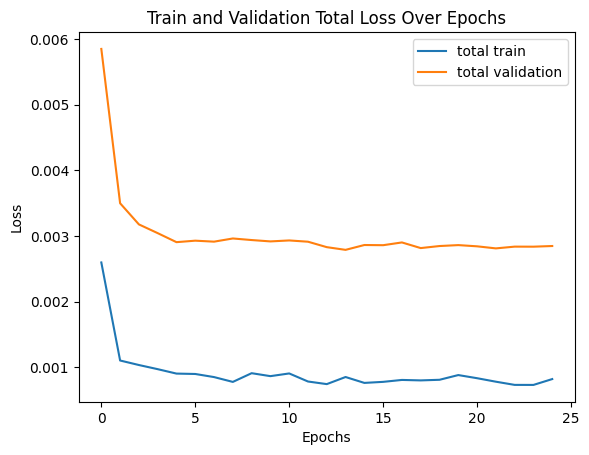

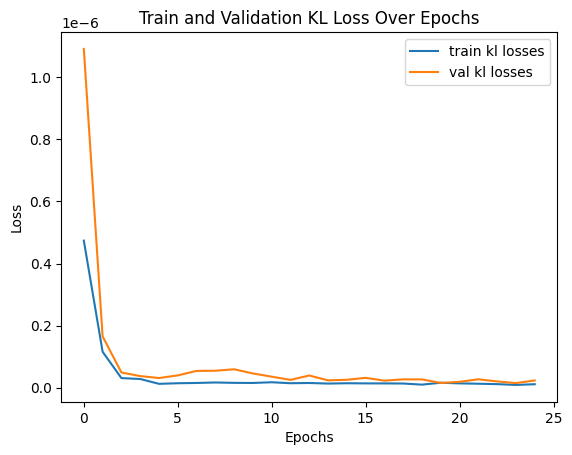

In [ ]:

import matplotlib.pyplot as plt
epochs = 25
plt.plot(range(epochs), train_results["train_loss_tot"], label='total train')
plt.plot(range(epochs), train_results["val_loss_tot"], label='total validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Total Loss Over Epochs')
plt.legend()
plt.show()

plt.plot(range(epochs), train_results["train_recon_tot"], label='train reconstruction loss')
plt.plot(range(epochs), train_results["val_recon_tot"], label='val reconstruction loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Reconstruction Loss Over Epochs')
plt.legend()
plt.show()

plt.plot(range(epochs), train_results["train_kl_tot"], label='train kl losses')
plt.plot(range(epochs), train_results["val_kl_tot"], label='val kl losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation KL Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import torch

# Define a function to denormalize images for visualization
def denormalize_image(image, mean, std):
    """
    Denormalize the image for visualization.
    """
    image = image * std + mean  # Undo normalization
    return image.clamp(0, 1)    # Clamp values between 0 and 1

# Get an original image and transform it
original_image = train_nps["front_cam_ob"][0]  # Example raw image from dataset
transformed_image = global_transforms["front_cam_ob"](original_image)

# Send the model and inputs to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae_model.to(device)
transformed_image = transformed_image.unsqueeze(0).to(device)

# Reconstruct the image using the VAE
vae_model.eval()
with torch.no_grad():
    reconstructed_image, _, _ = vae_model(transformed_image)
reconstructed_image = reconstructed_image.squeeze(0).cpu()

# Denormalize both images for visualization
original_image = denormalize_image(transformed_image.squeeze(0).cpu(), mean=0.5, std=0.5)  # Adjust mean and std based on transforms
reconstructed_image = denormalize_image(reconstructed_image, mean=0.5, std=0.5)

# Convert tensors to NumPy arrays for plotting
original_image_np = original_image.detach().numpy()
reconstructed_image_np = reconstructed_image.detach().numpy()

# Plot original and reconstructed images
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(original_image_np.squeeze(), cmap='gray')  # Adjust `squeeze` if required
axs[0].set_title("Original Image")
axs[1].imshow(reconstructed_image_np.squeeze(), cmap='gray')  # Adjust `squeeze` if required
axs[1].set_title("Reconstructed Image")
plt.show()


### Question 2.b Model convergence (12 marks)

##### Task
- Provide empirical evidence (in the form of appropriate training/validation metrics) supporting **why** the model is appropriately trained;
- Interpret why the metrics demonstrate that the model has converged. If your model has **not** converged, interpret why the metrics suggest so.

Training and validation total loss. The graphs show that training and validation losses decrease significantly in the first few epochs, suggesting that the model is learning to reconstruct the input data very effectively. After the initial declaration, the model losses for training and validation stabilise and demonstrate a small generalist gap; this suggests that the model is good at generalisation to unseen data without the risk of overfitting.

The VAE can also reconstruct images with high accuracy, the reconstruction losses show this for training and validation, which decrease and converge to a low value.

Furthermore, This VAE also leads to a regularised latent space, ensuring meaningful representations. This is shown by the rapid decrease in the KL divergence loss, which stabilises close to zero. The reconstructed images also show and closely resemble the original input images, preserving most of the critical features and structures. This suggests the model has effectively learned to encode and decode the given data.


### Question 2.c Latent space analysis (6 marks)

##### Task
- Using reasonable analysis, conclude whether the representation learnt by the self-supervised method will be beneficial for the downstream supervised task. **Empirical evidence** should be provided **however**, references to the performance of the self-superised method with a supervised head on the downstream task will be awarded __0 marks__.

The low and stable KL divergence shown on the graph suggests that the latent space distribution is well-regularised, meaning that the learned representations are meaningful and not arbitrary. The successful reconstruction of input images demonstrates that the latent space can capture useful and sufficient information from the input data. Thus, the VAE can be used for downstream supervised tasks. The difference between the training and validation is minimal, meaning the latent space generalises well. Hence, this model can be used for tasks related to representation transfer.
